# TSA with Facebook Prophet

Prophet was developed internally at Facebook by Sean J. Taylor and Ben Letham in
order to overcome two issues often encountered with other forecasting methodologies:
the more automatic forecasting tools available tended to be too inflexible and unable
to accommodate additional assumptions, and the more robust forecasting tools would
require an experienced analyst with specialized data science skills. Facebook was
experiencing too much demand for high-quality business forecasts than their analysts
were able to provide. In 2017, Facebook released Prophet to the public as open source
software.

Prophet was designed to optimally handle business forecasting tasks, which typically
feature any of these attributes:

- Time series data captured at the hourly, daily, or weekly level with ideally at least
a full year of historical data
- Strong seasonality effects occurring daily, weekly, and/or yearly
- Holidays and other special one-time events that don`t necessarily follow the
seasonality patterns but occur irregularly
- Missing data and outliers
- Significant trend changes that may occur with the launch of new features or
products, for example
- Trends that asymptotically approach an upper or lower bound
Out of the box, Prophet typically produces very high-quality forecasts. But it is also very
customizable and approachable by data analysts with no prior expertise in time series
data. As you`ll see in later chapters, tuning a Prophet model is very intuitive.
Essentially, Prophet is an additive regression model. This means that the model is simply
the sum of several (optional) components, such as the following:
- A linear or logistic growth trend curve
- An annual seasonality curve
- A weekly seasonality curve
- A daily seasonality curve
- Holidays and other special events
- Additional user-specified seasonality curves, such as hourly or quarterly,
for example

### Example of the components

To take a concrete example, let`s say we are modeling the sales of a small online retail
store over four years, from January 1, 2000, through the end of 2003. We observe that the
overall trend is constantly increasing over time from 1000 sales per day to around 1800
at the end of the time period. We also see that sales in spring are about 50 units above
average and sales in autumn are about 50 units below average. Weekly, sales tend to be
lowest on Tuesday and increase throughout the week, peaking on Saturday. Finally,
throughout the hours of the day, sales peak at noon and smoothly fall to their lowest at
midnight. This is what those individual curves would look like (note the different x-axis
scales on each chart):

<center><img src="images/1_4_model_components.png" width="500"/></center>

An additive model would take those four curves and simply add them to each other to
arrive at the final model for sales throughout the years. The final curve gets more and
more complex as the sub-components are added up:
<center><img src="images/1_5_Additive_model.png" width="500"/></center>

This preceding plot displays just the first year to better see the weekly and daily variations,
but the full curve extends for 4 years.

Prophet manages to achieve typical results just as good as the more complicated
forecasting techniques but with just a fraction of the effort. It has something for everyone.
The beginner can build a highly accurate model in just a few lines of code without
necessarily understanding the details of how everything works, while the expert can dig
deep into the model, adding more features and tweaking hyperparameters to eke out
incrementally better performance.

### Installation of Prophet

The installation is detailed in [this web](https://facebook.github.io/prophet/docs/installation.html#python).

For Linux using Anaconda or miniconda is very easy: `conda install -c conda-forge prophet`. In Mac or Windows, it is maybe necessary a previous step to install GCC: `conda install gcc`. 

### First (Simple) Model in Prophet

The longest record of direct measurements of CO2 in the atmosphere was started in March 1958 by Charles David Keeling of the Scripps Institution of Oceanography. Keeling was based in La Jolla, California, but had received permission from the National Oceanic and
Atmospheric Administration (NOAA) to use their facility located two miles above sea level on the northern slope of Mauna Loa, a volcano on the island of Hawaii, to collect carbon dioxide samples. At that elevation, Keeling`s measurements would be unaffected by
local releases of CO2, such as from nearby factories.

In 1961, Keeling published the data he had collected thus far, establishing that there was strong seasonal variation in CO2 levels and that they were rising steadily, a trend that later became known as the Keeling Curve. By May 1974, the NOAA had begun their
own parallel measurements and have continued since then.

In [79]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
import numpy as np
import random
random.seed(42)  # set random seed for repeatability

from fbprophet.plot import add_changepoints_to_plot


In [2]:
# All this code is for avoid the logs prints of stan when we are using prophet

import warnings
warnings.filterwarnings('ignore')

# Turn off pystan warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

# Turn off fbprophet stdout logger
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)
logging.getLogger('fbprophet').setLevel(logging.ERROR)


import os
class sup(object): # suppress_stdout_stderr
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through). 
    This is necessary to supress the log outputs of stan when Prophet is executed.

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

In [3]:
# Reading the CO2 ppm daily dataset
df = pd.read_csv('data/co2-ppm-daily_csv.csv')
df['date'] = pd.to_datetime(df['date']) # convert to a pandas datetime format
df.columns = ['ds', 'y']

The Keeling Curve graph is as follows:

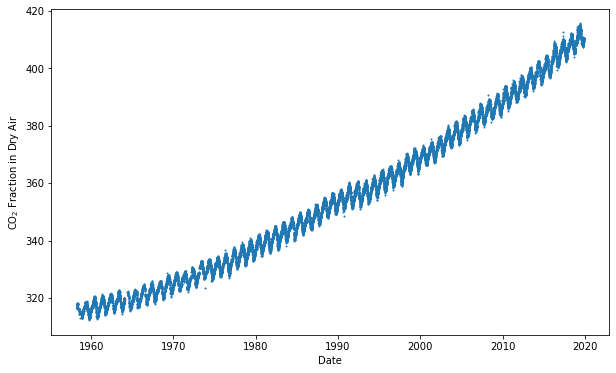

In [4]:
plt.figure(figsize=(10, 6))
plt.scatter(df['ds'], df['y'], s=1)
plt.xlabel('Date')
plt.ylabel('CO$_2$ Fraction in Dry Air')
plt.show()

As input, Prophet always requires a pandas DataFrame with two columns:
- `ds`, for datestamp, should be a datestamp or timestamp column in a format
expected by pandas.
- `y`, a numeric column containing the measurement we wish to forecast.

This is why previously we did `df.columns = [`ds`, `y`]`.convert the ds column to a pandas datetime formatconvert the ds column to a pandas datetime format.

Prophet follows the sklearn paradigm of first creating an instance of the model class before calling the `fit` and `predict` methods:

In [5]:
model = Prophet()
with sup():
    model.fit(df)

In that single `fit` command, Prophet analyzed the data and isolated both the seasonality and trend without requiring us to specify any additional parameters. It has not yet made any future forecast, though. To do that, we need to first make a DataFrame of future dates and then call the `predict` method. The `make_future_dataframe` method requires us to specify the number of days we intend to forecast out. In this case, we will choose 10 years, or 365 days, times 10:

In [6]:
future = model.make_future_dataframe(periods=365 * 10)
forecast = model.predict(future)

At this point, the forecast DataFrame contains Prophet`s prediction for CO2 concentrations going 10 years into the future. We will explore that DataFrame in a moment, but first let`s plot the data using Prophet`s `plot` functionality. The plot method is built upon Matplotlib; it requires a DataFrame output from the predict method (our forecast DataFrame in this example).

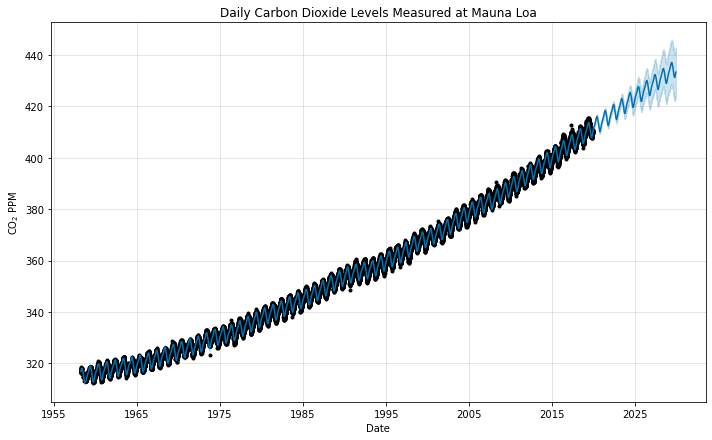

In [7]:
fig = model.plot(forecast, xlabel='Date', ylabel=r'CO$_2$ PPM')
plt.title('Daily Carbon Dioxide Levels Measured at Mauna Loa')
plt.show()

And that`s it! In those 12 lines of code, we have arrived at our 10-year forecast.

#### Interpeting the forecast DataFrame

Now, let`s take a look at that forecast DataFrame by displaying the first three rows (I`ve transposed it here, in order to better see the column names on the page) and learn how these values were used in the preceding chart:

In [8]:
forecast.head(3).T

,0,1,2
ds,1958-03-30 00:00:00,1958-03-31 00:00:00,1958-04-02 00:00:00
trend,314.88611,314.888515,314.893326
yhat_lower,316.061046,316.016294,316.151595
yhat_upper,317.738273,317.752144,317.843256
trend_lower,314.88611,314.888515,314.893326
trend_upper,314.88611,314.888515,314.893326
additive_terms,1.98538,2.015452,2.118277
additive_terms_lower,1.98538,2.015452,2.118277
additive_terms_upper,1.98538,2.015452,2.118277
weekly,0.003281,-0.01065,0.003347


The following is a description of each of the columns in the forecast DataFrame:
- `ds`: Datestamp or timestamp that values in that row pertain to
- `trend`: Value of the trend component alone
- `yhat_lower`: Lower bound of the uncertainty interval around the final
prediction
- `yhat_upper`: Upper bound of the uncertainty interval around the final
prediction
- `trend_lower`: Lower bound of the uncertainty interval around the trend
component
- `trend_upper`: Upper bound of the uncertainty interval around the trend
component
- `additive_terms`: Combined value of all the additive seasonalities
- `additive_terms_lower`: Lower bound of the uncertainty interval around
the additive seasonalities
- `additive_terms_upper`: Upper bound of the uncertainty interval around
the additive seasonalities
- `weekly`: Value of the weekly seasonality component
- `weekly_lower`: Lower bound of the uncertainty interval around the weekly
component
- `weekly_upper`: Upper bound of the uncertainty interval around the weekly
component
- `yearly`: Value of the yearly seasonality component
- `yearly_lower`: Lower bound of the uncertainty interval around the yearly
component
- `yearly_upper`: Upper bound of the uncertainty interval around the yearly
component
- `multiplicative_terms`: Combined value of all the multiplicative
seasonalities
- `multiplicative_terms_lower`: Lower bound of the uncertainty interval
around the multiplicative seasonalities
- `multiplicative_terms_upper`: Upper bound of the uncertainty interval
around the multiplicative seasonalities
- `yhat`: Final predicted value; a combination of `trend`, `multiplicative_
terms`, and `additive_terms`

If the data contains a daily seasonality, then columns for `daily`, `daily_upper`,and `daily_lower` will also be included, following the pattern established with the
`weekly` and `yearly` columns. 

In the last Figure, the black dots represent the actual recorded y values we fit on (those in the `df['y']` column), whereas the solid line represents the calculated yhat values (the `forecast['yhat']` column). Note that the solid line extends beyond the range of the black dots where we have forecasted into the future. The lighter shading notable around the solid line in the forecasted region represents the uncertainty interval, bound by `forecast['yhat_lower']` and `forecast['yhat_upper']`.

#### Understanding components plots

At the beginning Prophet was introduced as an additive regression model. Then, the following Figure showed how individual component curves for the trend and the different seasonalities are added together to create a more complex curve.

<center><img src="images/1_4_model_components.png" width="500"/></center>

The Prophet algorithm essentially does this in reverse; it takes a complex curve and decomposes it into its constituent parts. The first step toward greater control of a Prophet forecast is to understand these components so that they can be manipulated individually. Prophet provides a plot_components method to visualize these.

Continuing on with our progress on the Mauna Loa model, plotting the components is as simple as running these commands:

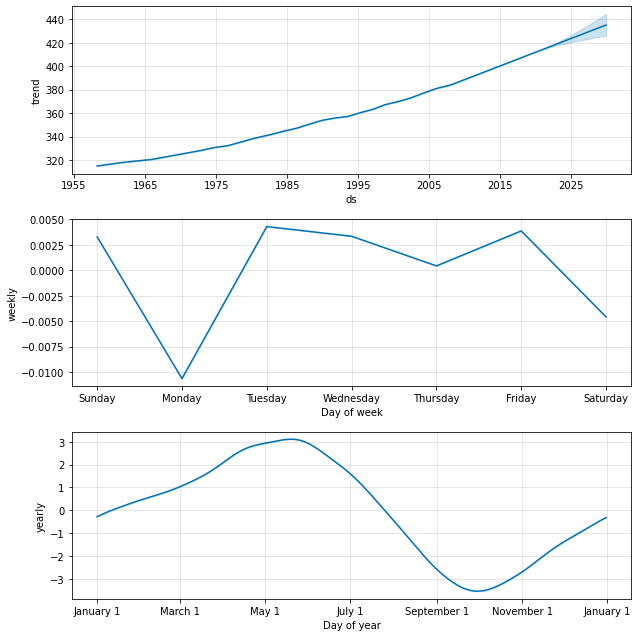

In [9]:
fig2 = model.plot_components(forecast)
plt.show()

As you can see in the output plot, Prophet has isolated three components in this dataset: **trend, weekly seasonality, and yearly seasonality**.

- The **trend** constantly increases but seems to have a steepening slope as time progresses-an acceleration of CO2 concentration in the atmosphere. The trend line also shows slim uncertainty intervals in the forecasted year. From this curve, we learn that atmospheric CO2 concentrations were about 320 ppm in 1965. This grew to about 400 by 2015 and we expect about 430 PPM by 2030. However, these exact numbers will vary depending upon the day of the week and the time of year, due to the existence of the seasonality effects.

- The **weekly** seasonality shows that by days of the week, values will vary by about 0.01 PPM—an insignificant amount and most likely due purely to noise and random chance.Indeed, intuition tells us that carbon dioxide levels (when measured far enough away from human activity, as they are on the high slopes of Mauna Loa) do not care much what day of the week it is and are unaffected by it.

- Now, looking at the **yearly seasonality** reveals that carbon dioxide rises throughout the winter and peaks in May or so, while falling in the summer with a trough in October. Measurements of carbon dioxide can be 3 PPM above or 3 PPM below what the trend alone would predict, based upon the time of year. If you refer back to the original data, you will be reminded that there was a very obvious cyclical nature to the curve, captured with this yearly seasonality.

# Non-Daily Data

When Prophet was first released, it assumed all data would be on a daily scale, with one row of data per day. It has since grown to handle many different granularities of data, but because of its historical conventions, there are few things to be cautious of when working with non-daily data.

Now, we will look at monthly data (and in fact, any data that is measured in timeframes greater than a day) and see how to change the frequency of predictions to
avoid unexpected results. You will also look at hourly data and observe an additional component in the components plot. Finally, you will learn how to handle data that has regular gaps along the time axis.

## Using monthly data

Previously, we built our first Prophet model using the Mauna Loa dataset. The data was reported every day, which is what Prophet
by default will expect and is therefore why we did not need to change any of Prophet's default parameters. In this next example, though, let's take a look at a new set of data that is not reported every day, **the Air Passengers dataset**, to see how Prophet handles thisdifference in data granularity.

This is a classic time series dataset spanning 1949 through 1960. It counts the number of passengers on commercial airlines each month during that period of explosive growth in the industry. The Air Passengers dataset, in contrast to the Mauna Loa dataset, has
one observation per month. What happens if we attempt to predict future dates?
Let's create a model and plot the forecast to see what happens. We begin as we did with the Mauna Loa example, by importing the necessary libraries and loading our data into a properly formatted DataFrame:

In [10]:
df = pd.read_csv('data/AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.columns = ['ds', 'y']
df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


The data is reported on a monthly basis, with one measurement for each month. Passenger numbers are reported per thousand, which means that the first row indicates that 112,000 commercial passengers took to the skies during the month beginning January 1, 1949.

Just as we did with Mauna Loa in the previous section, we will next instantiate our model and fit it. With this *Air Passengers dataset*, we will set `seasonality_mode` to `'multiplicative'` (but don't concern yourself with this for now—we'll cover it later). Next, we send our data to the `fit` method and then make a `future` DataFrame. Let's  forecast `5` years. Finally, we will use `predict` with the future and then plot the forecast to see how we did:

In [11]:
model = Prophet(seasonality_mode='multiplicative')
with sup():
    model.fit(df)

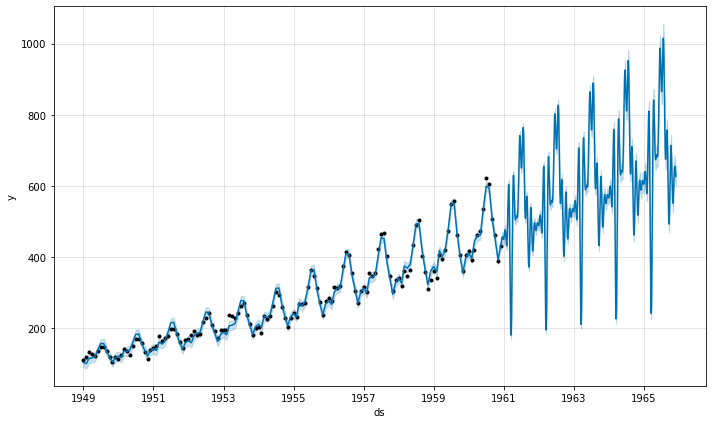

In [12]:
future = model.make_future_dataframe(periods=365 * 5)
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

We can fix this by instructing Prophet to only forecast on a monthly scale, to match the monthly data it is trained on. We need to specify a frequency in the `make_future_dataframe method`, and we do this by passing the freq argument. We must also update periods because although we are still forecasting 5 years into the future, we only want 12 entries per year, one for each month:

In [13]:
model = Prophet(seasonality_mode='multiplicative')
with sup():
    model.fit(df)

The `freq` argument accepts anything that pandas identifies as a frequency string. In this case, we used `'MS'`, for month start. Here is the output of that code block, the plotted forecast once Prophet is instructed to predict only on the first day of each month.

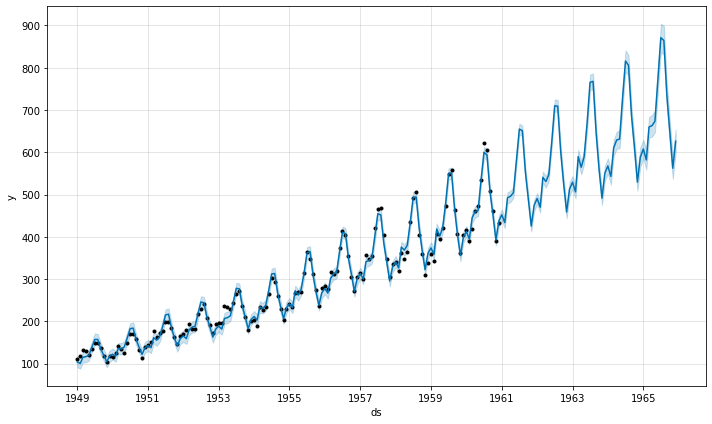

In [14]:
future = model.make_future_dataframe(periods=12 * 5, freq='MS')
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

That's much better, exactly what we might expect the forecast to look like. By feeding the freq argument to the `make_future_dataframe method`, we do not make themistake of asking Prophet to forecast dates for which it has no training knowledge. By default, the frequency is set to `'D'`, for daily, and our periods would be the number of days we want to forecast. Whenever changing the frequency to some other setting, be sure to set your periods to be on the same scale.

## Using sub-daily data

In this section, we will be using data from the **Divvy bike share program** in Chicago, Illinois. The data contains the number of bicycle rides taken each hour from the beginning of 2014 through the end of 2018 and exhibits a general increasing trend along with very strong yearly seasonality. Because it is hourly data and there are very few rides overnight (sometimes zero per hour), the data does show a density of measurements at the low end:

In [15]:
df = pd.read_csv('data/divvy_hourly.csv')
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y']

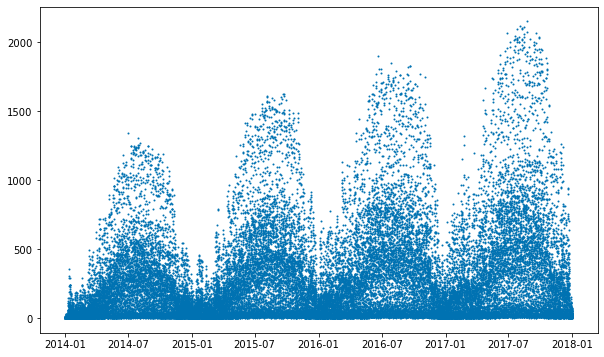

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['y'], s=1, c='#0072B2')
plt.show()

Using **sub-daily data** such as this is much the same as using **super-daily data**, as we did with the *Air Passengers* data previously. You as the analyst need to use the `freq` argument and adjust the periods in the `make_future_dataframe` method, and Prophet will do the rest. If Prophet sees at least two days of data and the spacing between data is less than one day, it will fit a daily seasonality.

Next, we continue as we did in the previous example by instantiating our model (again, using `seasonality_mode='multiplicative'`, and again, not worrying about it for now) before fitting our model. When we create the `future` DataFrame, we again need to set a frequency but this time we will use `'h'`, for hourly.

Now that our frequency is hourly, we need to adjust our period to match, so we multiply the 365-day forecast we want by 24 hours per day:

In [17]:
model = Prophet(seasonality_mode='multiplicative')
with sup():
    model.fit(df);
future = model.make_future_dataframe(periods=365 * 24, freq='h')

Finally, we will predict our `future` DataFrame. With our forecast complete, we will plot it in the first plot function and then the components in the second plot function:

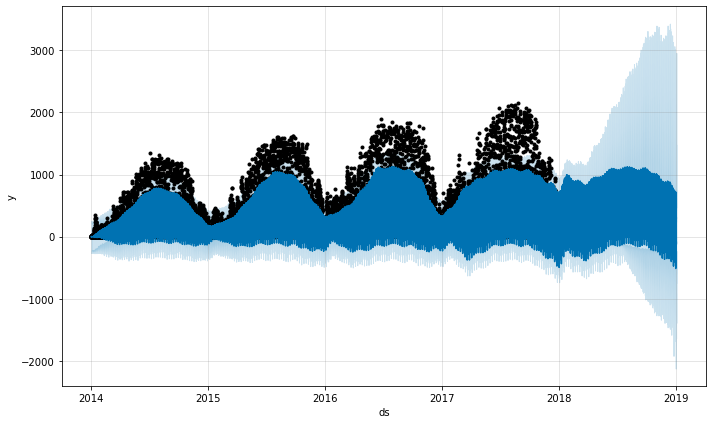

In [18]:
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

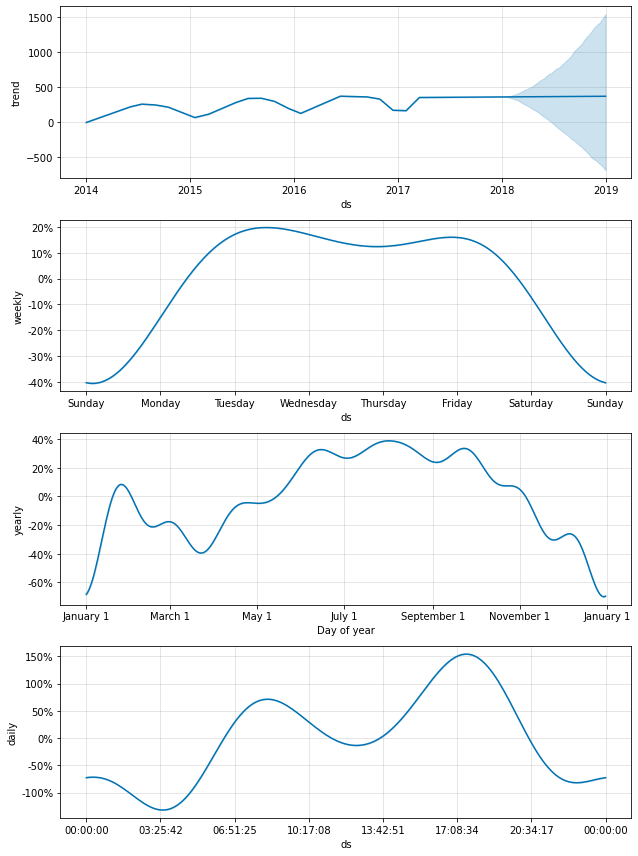

In [19]:
fig2 = model.plot_components(forecast)
plt.show()

#### Some observations 

- The trend plot, we can see that it still exhibits annual periodicity. Why wasn't this captured in the yearly seasonality plot? Unfortunately, this data contains some very complex seasonalities that Prophet is unable to fully model.

- In particular, the daily seasonality itself is seasonal within the year. It's seasonality within seasonality. The daily seasonality rises in the day and falls in the night, but the amount of the increase is dependent upon the time of year, and Prophet is not built to capture this type of seasonality. This is what causes so much forecast uncertainty. It is possible learn a few techniques to control this.

- Next, we look at the weekly seasonality plot. In contrast to the Mauna Loa example, this plot displays a single curved line.The Mauna Loa plot featured several straight-line segments. Also, the plot goes from Sunday to Sunday, whereas the Mauna Loa plot went from Sunday to Saturday. Both of these changes are to reflect the more continuous nature of hourly data.

- When we only had daily data, as we did with Mauna Loa, the weekly seasonality only needed to show the effect of each day (although, under the hood, it still is a continuous model). But now that we have hourly data, it is important to see the continuous effect. We are seeing 12:00:00 am on Sunday through 11:59:59 pm on Saturday, which is 1 second shy of 8 days. The Mauna Loa plot in essence showed the daily effect at a single moment each day, exactly 7 days, hence the difference between the two plots.

- Now take a look at the yearly seasonality. It's quite wavy. Just take note of that for now. We'll talk about it later,  when we learn about Fourier order in Seasonality,.

- Finally, the daily seasonality plot. This is new and only appears when Prophet models sub-daily data. It's quite revealing with this dataset, though. It seems that riders in the Divvy network ride a lot around 8am, possibly commuting to work. There is an even larger spike just after 5pm, possibly riders returning home. And finally, there's a small hump just after midnight. These must be the night-owls, who spent the evening out with friends and are returning home to bed.

## Using data with regular gaps

Throughout your career, you may encounter datasets with regular gaps in reporting,
particularly when the data was collected by humans who have working hours, personal
hours, and sleeping hours. It simply may not be possible to collect measurements with
perfect periodicity.

As you will see when we look at outliers, Prophet is robust in handling missing values. However, when that missing data occurs at regular intervals, Prophet will have no training data at all during those gaps to make estimations with. The seasonality will be constrained during periods where data exists but unconstrained during the gaps, and Prophet's predictions can see much larger fluctuations than the actual data displayed.
Let's see this in action.

Suppose that Divvy's data had only been collected between the hours of 8am and 6pm
each day. We can simulate this by removing data outside these hours from our DataFrame:

In [20]:
df = df[(df['ds'].dt.hour >= 8) & (df['ds'].dt.hour < 18)]

Now compare the following plot of this new DataFrame with the full dataset, which we
saw above (cell 6):

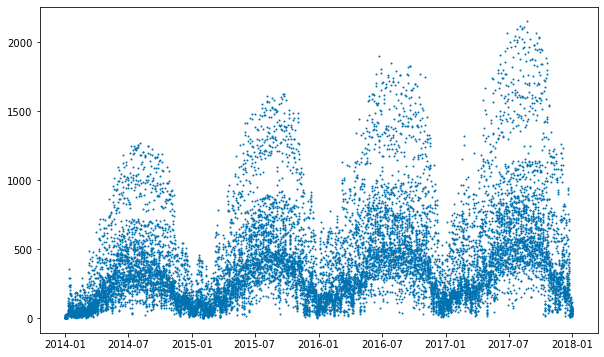

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['y'], s=1, c='#0072B2')
plt.show()

This plot is much sparser than the previous Figure, being particularly low for the y-axis values. Welost all overnight data, when ridership is down. Each day only has 10 data points now, one for each hour between 8am and 6pm. Now, let's build a forecast model exactly as we did in the previous section, making our `future` DataFrame with one year of hourly frequency,
but taking no extra precautions:

In [22]:
%%capture 
model = Prophet(seasonality_mode='multiplicative')
with sup():
    model.fit(df)

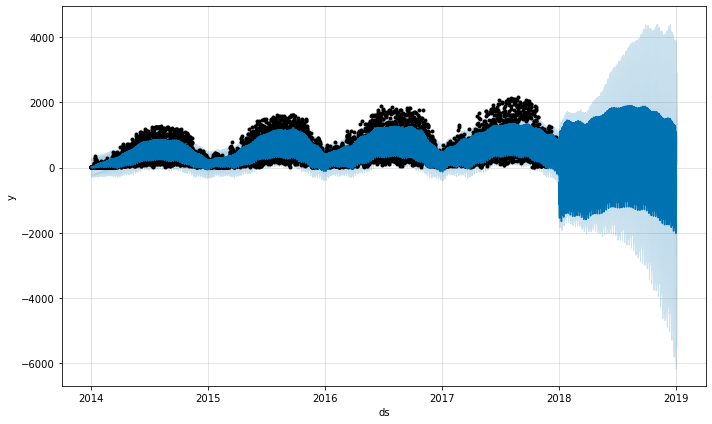

In [23]:
future = model.make_future_dataframe(periods=365 * 24, freq='h')
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

The plotted forecast shows much wider daily fluctuations in the future period than the
historical training data.

What we are seeing there are unconstrained estimates in the future period causing wide fluctuations in predictions. This is the same effect that we observed with the Air Passengers data, when we predicted daily forecasts with monthly data. We can zoom in on just 3 days in August 2018 to see more clearly what's going on by replotting and using Matplotlib to constrain the limits of the x and y axes:

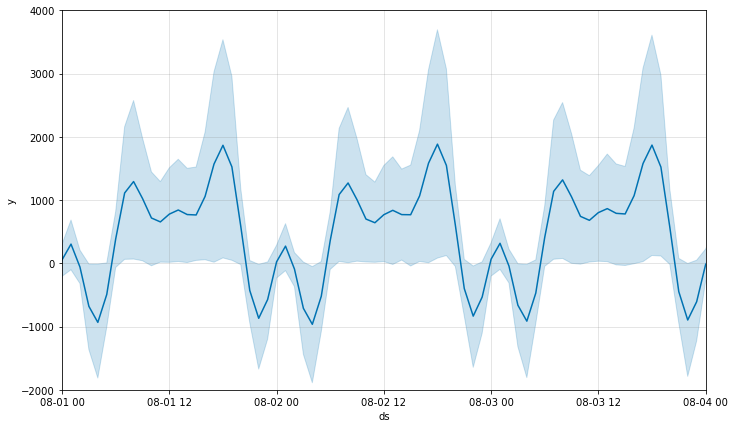

In [24]:
fig = model.plot(forecast)
plt.xlim(pd.to_datetime(['2018-08-01', '2018-08-04']))
plt.ylim(-2000, 4000)
plt.show()

Whereas the forecast plot from before showed 5 years of predictions, this plot shows just 3
days, so you can fully see what's going on.

In the previous section, when we looked at Figure of cell 18, we noted that the daily seasonality
component showed ridership picking up before 8am and hitting a local peak right at 8am. There was a slump at midday and then a large peak right after 6pm. We are seeing the same thing in the last Figure, except that Prophet is making wild predictions before 8am and after 6pm, where it has no training data. This area is unconstrained and could follow almost any pattern as long as the equations work out for the midday period where data exists.

The solution to this problem is to simply modify the future DataFrame to exclude those times where our training data had regular gaps. We don't even need to instantiate a new model or refit; we can just reuse our previous work. So, continuing on, we create a new future2 DataFrame, remove those times earlier than 8am and later than 6pm, and then predict our forecast and plot the results:

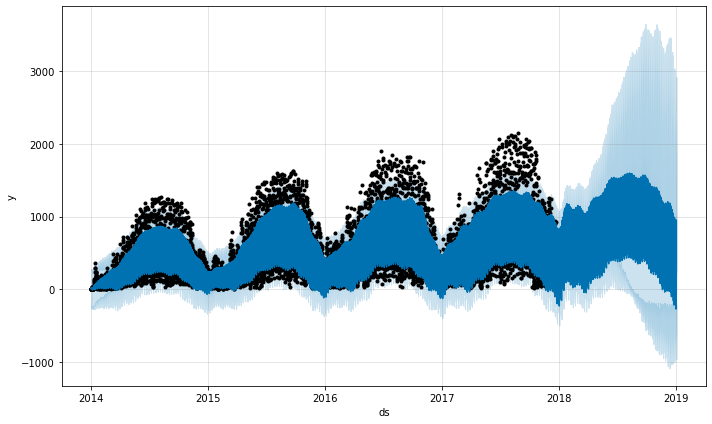

In [25]:
future2 = future[(future['ds'].dt.hour >= 8) &  (future['ds'].dt.hour < 18)]
forecast2 = model.predict(future2)
fig = model.plot(forecast2)
plt.show()

Now we see a good forecast. The daily fluctuations in the predicted future are of the same magnitude as our historical training data. 

Let's again plot those same 3 days in August:

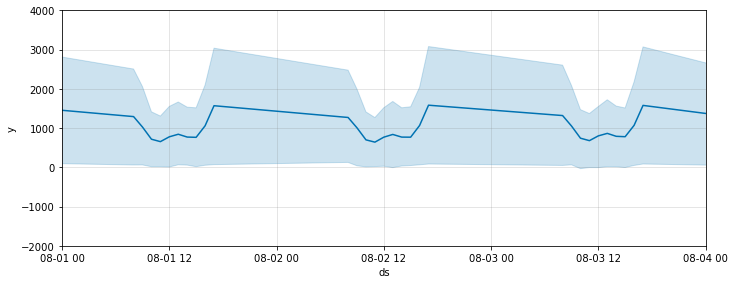

In [26]:
fig = model.plot(forecast2, figsize=(10, 4))
plt.xlim(pd.to_datetime(['2018-08-01', '2018-08-04']))
plt.ylim(-2000, 4000)
plt.show()

We see the same curve as before for the hours between 8am and 6pm, but this time Prophet simply connects them with a straight line. There is, in fact, no data in our forecast DataFrame for these time periods; Prophet simply ignores them. 

Prophet is a continuous-time model, so although the *forecast* DataFrame ignores those excluded times, the equations that underpin the model are defined continuously. We can observe this by plotting the daily seasonality with the `fbprophet.plot.plot_seasonality function`. It takes two required arguments, the model and a string identifying the seasonality to plot, and we are also passing an optional argument to change the figure size.

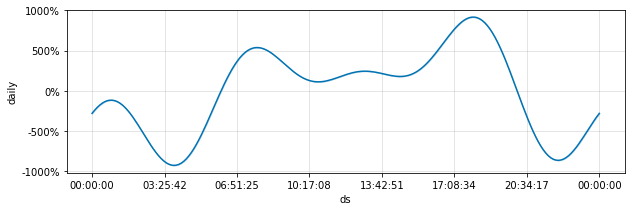

In [27]:
from fbprophet.plot import plot_seasonality
plot_seasonality(model, 'daily', figsize=(10, 3))
plt.show()

As you can see, the period from 8am until 6pm matches previous figures (cells 28 and 24), even though those two plots showed wildly different results overnight. As we have no training or future data for times outside that range, those times on the daily seasonality plot can be ignored. They are merely mathematical artifacts of the equations that created the midday curve.

# Seasonality

One quality that sets time series apart from other datasets is that very often—but not always—the data has a certain rhythm to it. That rhythm may be yearly, possibly due to the Earth's rotation around the Sun, or daily, if rooted in the Earth's rotation around its axis. The tidal cycle follows the Moon's rotation around the Earth. 

Traffic congestion follows the human activity cycle throughout the day and the five-day workweek followed by the two-day weekend; financial activity follows the quarterly business cycle. Your own body follows cycles due to your heartbeat, breathing rate, and circadian rhythm. On the very small physical and very short temporal scales, the vibration of atoms is a cause of periodicity in data. Prophet calls these cycles **seasonalities**. 

In this section, you will learn about all the different types of seasonalities Prophet fits by default, how to add new ones, and how to control them. In particular, we will cover the following:
- Understanding additive versus multiplicative seasonality 
- Controlling seasonality with Fourier order 
- Adding custom seasonalities 
- Adding conditional seasonalities 
- Regularizing seasonality

## Understanding additive versus multiplicative seasonality

In our Mauna Loa example, the yearly seasonality was constant at all values along the trend line. We added the values predicted by the seasonality curve to the values predicted by the trend curve to arrive at our forecast. There is an alternative mode of seasonality though, where we would multiply the trend curve by the seasonality. Take a look at this figure:

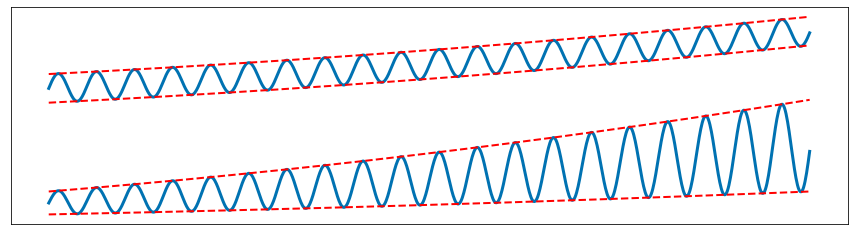

In [28]:
multiplier = 5; spread = 3; separation = 10 * spread
x = np.linspace(1, 2, 1000)
y0 = [multiplier * val**2 for val in x]
y1 = [np.sin(idx * 7.2 * np.pi / 180) for idx in range(len(x))]
y = [y0[idx] + 1.25 * spread * y1[idx] for idx in range(len(x))]
upper = [y0[idx] + 1.25 * spread for idx in range(len(x))]
lower = [y0[idx] - 1.25 * spread for idx in range(len(x))]
plt.figure(figsize=(15, 4)); plt.plot(x, y, c='#0072B2', lw=3)
plt.plot(x, upper, c='r', lw=2, ls='--'); plt.plot(x, lower, c='r', lw=2, ls='--')
y = [y0[idx] + spread / multiplier * y0[idx] * y1[idx] - separation for idx in range(len(x))]
upper = [(multiplier + spread) * val**2 - separation for val in x]
lower = [(multiplier - spread) * val**2 - separation for val in x]
plt.plot(x, y, c='#0072B2', lw=3)
plt.plot(x, upper, c='r', lw=2, ls='--'); plt.plot(x, lower, c='r', lw=2, ls='--')
plt.xticks([]); plt.yticks([]);plt.show()

The upper curve demonstrates additive seasonality—the dashed lines that trace the bounds of the seasonality are parallel because the magnitude of seasonality does not change, only the trend does. In the lower curve though, these two dashed lines are not parallel. Where the trend is low, the spread caused by seasonality is low; but where the trend is high, the spread caused by seasonality is high. This can be modeled with multiplicative seasonality.

Let's look at a concrete example using the Air Passengers dataset introduced in the previously. This data records the number of commercial airline passengers per month from 1949 to 1960. We will first model it using Prophet's default seasonality_ mode, the additive mode that we used with the Mauna Loa example, and then contrast it with the multiplicative mode.

In [29]:
df = pd.read_csv('data/AirPassengers.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.columns = ['ds', 'y']

Let's continue building our model. I am calling this one `model_a` to indicate that it is our additive model, and I'll call the next model `model_m`, for multiplicative:

In [30]:
model_a = Prophet(seasonality_mode='additive', yearly_seasonality=4)
with sup():
    model_a.fit(df)

When we instantiated the Prophet object, we explicitly declared seasonality_mode to be `'additive'` for clarity's sake. By default, if no seasonality_mode is stated, then Prophet will automatically select `'additive'`. Also note that we set yearly_ seasonality=4. That merely sets the **Fourier order** for the curve, but don't worry about this for now because we'll go over it later.

After creating the Prophet model, we fit and predicted it just as before in the Mauna Loa example, and then plotted the forecast. Note that in this example though, we never created a future DataFrame—if no future DataFrame is sent to the `predict` method, it simply creates predicted values for the historical data it received in the `fit` method but no future predicted values. As we are only interested in seeing how Prophet has handled the seasonality, we don't need a future forecast.

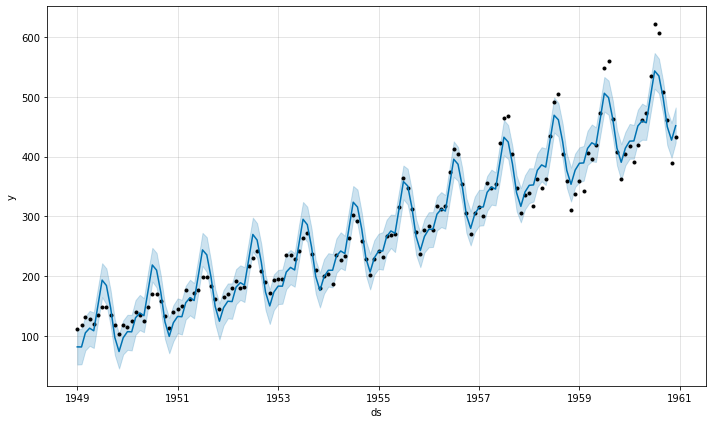

In [31]:
forecast_a = model_a.predict()
fig_a = model_a.plot(forecast_a)
plt.show()

As you can see, early in the data, in 1949, 1951, and 1952, Prophet's predicted values (the solid line) have large seasonal swings that are more extreme than the data (the dots) indicates. Later in the series, in 1958, 1959, and 1960, Prophet's predicted seasonality is less extreme than the data indicates. The seasonal spread of the data is increasing, but we have predicted it to be constant. That's the mistake of choosing additive seasonality when multiplicative is required. Let's run the model again, but this time we will use multiplicative seasonality:

In [32]:
model_m = Prophet(seasonality_mode='multiplicative', yearly_seasonality=4)
with sup():
    model_m.fit(df)

We do everything the same as the previous example, except this time we set seasonality_mode='multiplicative'. We see this change reflected in the figure we produce:

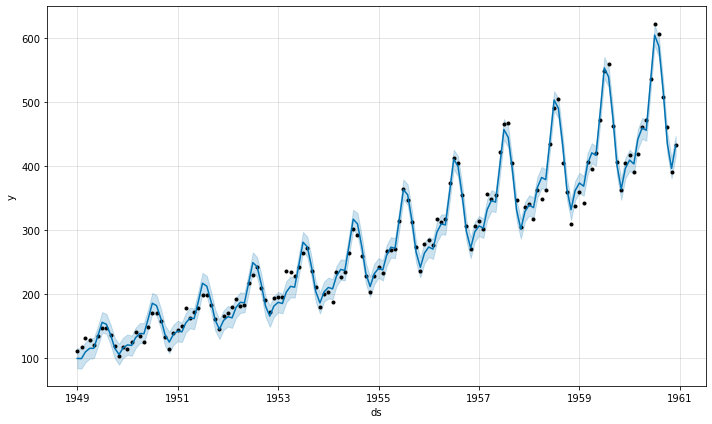

In [33]:
forecast_m = model_m.predict()
fig_m = model_m.plot(forecast_m)
plt.show()

That's a much better fit! Now, Prophet is matching the growth of the seasonality swings along with the growth of the overall trend. Also, compare the error estimates between the above two figures (the light shaded area surrounding the solid line). Prophet shows wider uncertainty intervals when it attempts to fit additive seasonality to a series of data containing multiplicative seasonality. Prophet knows that it does not have a good fit in the former model and is less certain about its predictions. 

There's one last thing here I want you to note. Let me show you what it is by plotting the components. First, we plot the components of our `model_a` with additive seasonality:

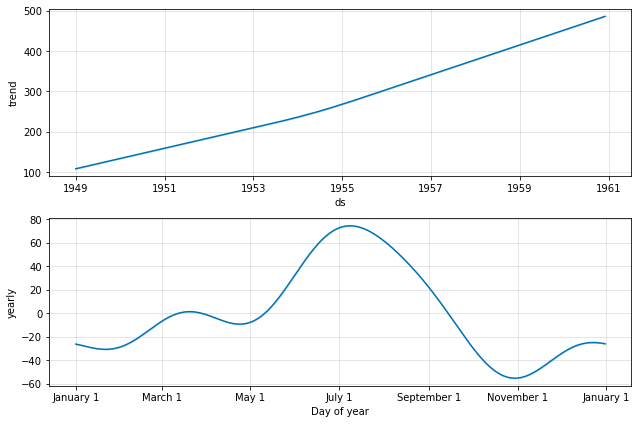

In [34]:
fig_a2 = model_a.plot_components(forecast_a)
plt.show()

And now, let's plot the components for `model_m`, and we'll compare this next plot with the previous figure:

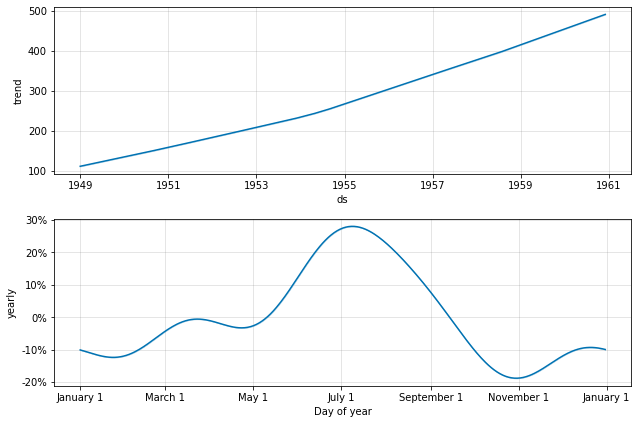

In [35]:
fig_m2 = model_m.plot_components(forecast_m)
plt.show()

They look almost identical. The trend is the same, starting in 1949 just above 100 and rising to just below 500 by 1961, with a slight kink in 1954 where the trend accelerates. The yearly seasonality behaves as we might expect, with the peak number of air passengers occurring in the summer and smaller local peaks over the Christmas holidays and Spring Break. **The difference between the two charts is the y-axis of the seasonality curve**.

In the additive model, the y-axis values are absolute numbers. In the multiplicative model, they are a percentage. This is because with an additive seasonality mode, the seasonality is modeled as an additional factor to the trend, simply adding or subtracting values from it. But in the multiplicative seasonality mode, the seasonality represents a relative deviation from the trend, so the magnitude of the seasonality effect will depend on what value the trend is predicting at that point; the seasonality effect is a percentage of the trend.

<font color='green'> When your data represents a count of something over time, such as the count of airline passengers each month, you will very often model it with multiplicative seasonality. Using additive seasonality can cause negative values to be predicted (negative 100 passengers per month, for example, is not possible), whereas multiplicative seasonality will merely shrink values closer to zero.</font>

Choosing additive versus multiplicative seasonality can be a bit tricky at first, but if you just remember the insight that the seasonality may be an absolute factor or a relative factor and observe whether the spread of the data is constant or not, you should have no trouble with your models.

#### Another example with the Divvy bike share dataset

Frequently, we will be creating examples using data from the Divvy bike share program in Chicago. Previously, we used hourly Divvy data, but now, we will use daily data.

In [36]:
df = pd.read_csv('data/divvy_daily.csv')
df.head()

,date,rides,temperature,weather
0,1/1/2014,95,19.483158,rain or snow
1,1/2/2014,111,16.833333,rain or snow
2,1/3/2014,6,-5.633333,clear
3,1/4/2014,181,30.007735,rain or snow
4,1/5/2014,32,16.756250,rain or snow


For now, though, we only need the date and rides columns. Let's load those into our Prophet DataFrame with the appropriate column names. We will work with weather and temperature when we study Additional Regressors:

In [37]:
df = df[['date', 'rides']]
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y']

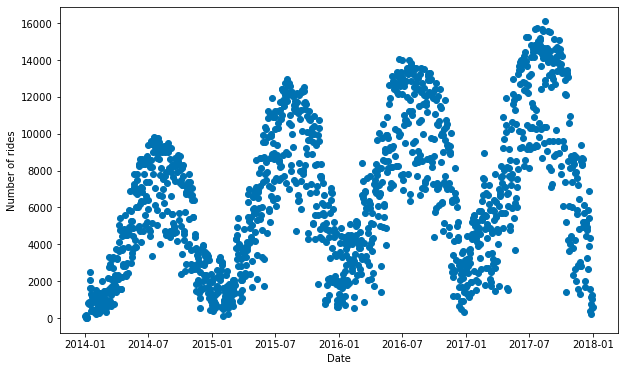

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['y'], c='#0072B2')
plt.xlabel('Date')
plt.ylabel('Number of rides')
plt.show()

This is count data, because it represents the number of rides each day, and you can also see that the magnitude of the seasonality is growing with the trend. As we just learned, these are an indication of multiplicative seasonality, so let's be sure to set that when instantiating our model.

As before, we need to create an instance of the Prophet class before calling the fit method. Note that we are setting `seasonality_mode` to `'multiplicative'` because we noticed when plotting the raw data that the seasonality fluctuations were growing with the increasing trend. After fitting the model, we will again create a future DataFrame, with a one-year forecast, and then call `predict` to create the `forecast` DataFrame and send it to the `plot` method:

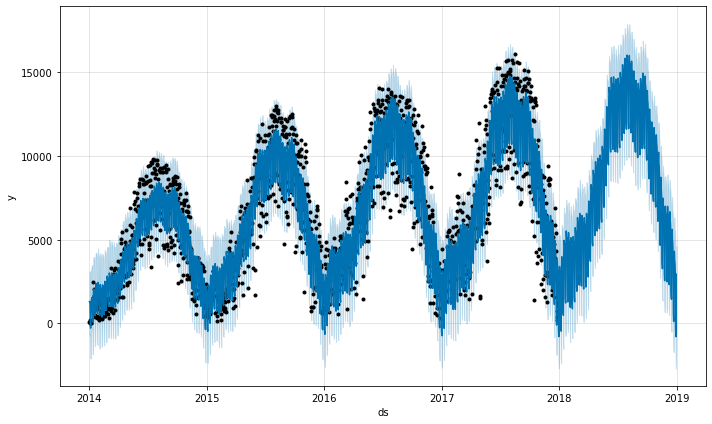

In [39]:
model = Prophet(seasonality_mode='multiplicative')
with sup(): model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

We can see that the predicted trend is indeed increasing along with the actual data and that the yearly seasonality also matches. Let's now plot our components and see what they reveal:

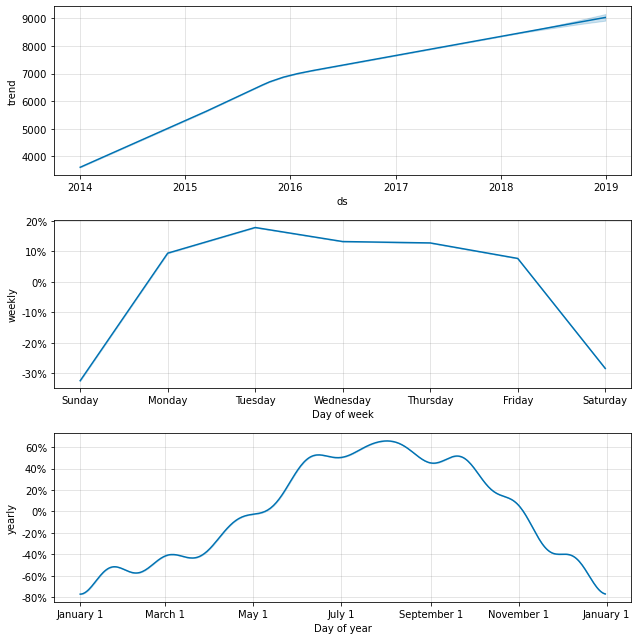

In [40]:
fig2 = model.plot_components(forecast)
plt.show()

As you can see in the output plot, Prophet has isolated three components in this dataset: the **trend**, a **weekly** seasonality, and a **yearly** seasonality.

By default, Prophet will identify a **yearly** seasonality whenever the `'ds'` column contains at least two full years of data. **Weekly** seasonality will be included when there are at least two weeks of data and the spacing between dates is less than seven days. There is also a default daily seasonality, which we saw previously, which would be included if the dataset both contained at least two days of data (which of course in this case it does) and the spacing between rows in the `'ds'` column is less than one day (which fails in this case). 

The trend linearly increases relatively rapidly for the first two years but then bends and slows slightly for the remaining two years, and the forecasted year continues to follow this slope. We can see that the Divvy network has grown in average usage over this time period from about 3500 rides per day in 2014 to about 8500 per day by the end of 2018. 

The weekly seasonality shows that there are about 30% fewer rides per day on the weekends—maybe all these riders are work commuters—with rides on the weekdays being 10–20% higher than the trend would indicate. This fits our intuition that weekdays and weekends could reasonably show a different pattern.

Now, looking at the yearly seasonality reveals that rides in the summer are about 60% higher than the trend, while rides in the winter are 80% lower. Again, this also intuitively makes sense. Those work commuters are going to drive or take public transport when the weather gets cold and rainy.

<font color='green'> You'll notice that this yearly seasonality curve is quite wavy, just as we noticed with the hourly Divvy data. You may have expected a much smoother curve, not one with so many inflection points. This is a result of our yearly seasonality being too flexible, it has too many **degrees of freedom**, or too many mathematical parameters controlling the curve. In Prophet, the number of parameters controlling the seasonality curve is called the **Fourier order**.

## Controlling seasonality with Fourier order

We can approximate arbitrary smooth seasonal effects with

$$
s(t)=\sum_{n=1}^{N}\left(a_{n} \cos \left(\frac{2 \pi n t}{P}\right)+b_{n} \sin \left(\frac{2 \pi n t}{P}\right)\right)
$$

a standard Fourier series $^{2}$. Fitting seasonality requires estimating the $2 N$ parameters $\boldsymbol{\beta}=$ $\left[a_{1}, b_{1}, \ldots, a_{N}, b_{N}\right]^{\top}$. 

A Fourier series is simply a sum of sine waves. By changing the shape of these individual sine waves—the amplitude, or height of the wave; the period, or distance from peak-to- peak; and the phase, or where along the length of the wave the cycle begins—we can creat a new and very complex wave shape.

In the linear domain, we changed the order of the polynomial to control the amount of flexibility the curve has, and we changed the β coefficients to control the actual shape of the curve. Similarly, in the periodic domain, we change the number of sine waves in our Fourier series—this is the Fourier order—to control the flexibility of the final curve and we (or, more accurately, Prophet's fitting equations) change the amplitude, period, and phase of the individual waves to control the actual shape of our final curve. You can see how this summation works in the following figure:

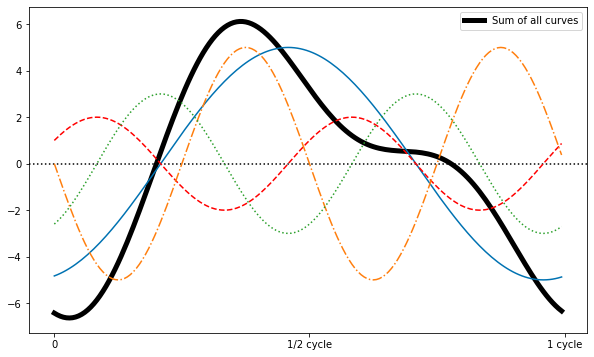

In [41]:
x = pd.date_range('2000-01-01', '2001-01-01', freq='H')
x = range(24 * 7)
y0 = [(-5 * np.sin(((idx / 7) - 17) * (360 / 24) * (np.pi / 180))) for idx in range(len(x))]
y1 = [(-2 * np.sin(((idx / 7) - 5) * (360 / 12) * (np.pi / 180))) for idx in range(len(x))]
y2 = [(-5 * np.sin(((idx / 7) - 12) * (360 / 12) * (np.pi / 180))) for idx in range(len(x))]
y3 = [(-3 * np.sin(((idx / 7) - 20) * (360 / 12) * (np.pi / 180))) for idx in range(len(x))]
y = [y0[idx] + y1[idx] + y2[idx] + y3[idx] for idx in range(len(x))]

plt.figure(figsize=(10, 6))
plt.axhline(0, ls=':', c='k')
plt.plot(y, lw=5, c='k', label='Sum of all curves')
plt.plot(y0, c='#0072B2', ls='-')
plt.plot(y1, c='r', ls='--')
plt.plot(y2, c='tab:orange', ls='-.')
plt.plot(y3, c='tab:green', ls=':')
plt.legend()
plt.xticks(ticks=[0, 84, 168], labels=[0, '1/2 cycle', '1 cycle'])
plt.show()

The solid line is simply the sum of each of the four sine waves. By arbitrarily increasing the Fourier order in our model, we can always achieve a perfect fit for any set of data. But just as in the linear domain, this approach will inevitably lead to overfitting.

Remember when we plotted the components of the Divvy forecast and the yearly seasonality was too wavy? This is the result of a Fourier order being too high. By default, Prophet fits yearly seasonality with an order of 10, weekly seasonality with an order of 3, and daily seasonality (if sub-daily data is provided, of course) of 4. Usually, these defaults work very well and no tuning is needed. However, in Divvy's case, we do need to reduce the Fourier order of the yearly seasonality in order to achieve a better fit with the data. Let's see how to do that.

As before, we will set the seasonality mode to multiplicative, but this time we will include the yearly_seasonality argument and set it to 4. This is where we set the **Fourier order**.

You may experiment with different values on your own; I have found 4 to provide a clean curve without much flexibility in most cases, which is what I want here. Similarly, if we wanted to change the **Fourier order** of `weekly_seasonality` or `daily_ seasonality`, we would do so here.

In [42]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4)
with sup(): model.fit(df)

In [43]:
from fbprophet.plot import plot_yearly

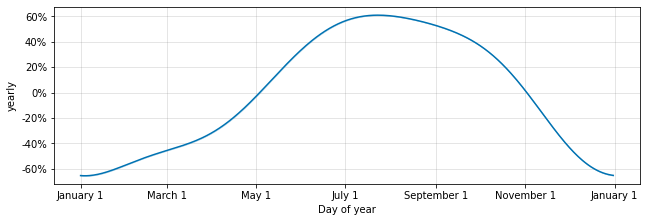

In [44]:
fig3 = plot_yearly(model, figsize=(10.5, 3.25))
plt.show()

We have successfully eliminated the waviness of our previous attempt, while still maintaining the clear shape of the seasonality. This seems much more reasonable!

Note that there is also a plot_weekly function, which operates much the same way. Both functions require the first argument to be the model.

## Adding custom seasonalities

So far, the only seasonalities we have worked with are the defaults in Prophet: yearly, weekly, and daily. But there is no reason to limit ourselves to these seasonalities. If your data contains a cycle that is either longer or shorter than the 365.25-day yearly cycle, the 7-day weekly cycle, or the 1-day daily cycle, Prophet makes it easy to model this seasonality yourself. 

A great example of a non-standard seasonality is the 11-year cycle of sunspots. Sunspots are regions on the Sun's surface that temporarily exhibit a much-reduced temperature, and hence appear much darker, than surrounding areas.

Beginning in approximately 1609, Galileo Galilei began systematic observation of sunspots and over the last 400+ years, this phenomenon has been constantly recorded. In fact, sunspots represent the longest continuously recorded time series of any natural phenomenon. Through these observations, scientists have identified a quasi-periodic cycle of 11 years during which the frequency of sunspot occurrences varies. They say quasi-periodic because the cycle length seems to vary from cycle to cycle—it isn't perfectly 11 years each time. The average cycle length is 11 years though, so that is what we will use to model it.

The **Solar Influences Data analysis Center (SIDC)**, a department of the Royal Observatory of Belgium in Brussels, makes available a dataset of sunspot activity from 1750 to the present day in their **World Data Center – Sunspot Index and Long-term Solar Observations (WDC-SILSO)** project. This dataset will be a good demonstration of how to add a new seasonality to Prophet. We begin by loading our data:

In [45]:
df = pd.read_csv('data/sunspots.csv', usecols=['Date', 'Monthly Mean Total Sunspot Number'])
df['Date'] = pd.to_datetime(df['Date'])
df.columns = ['ds', 'y']

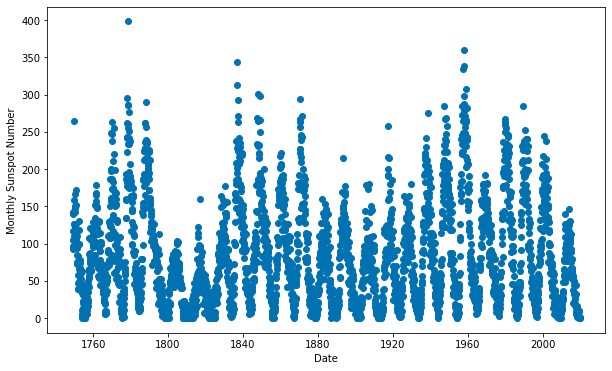

In [46]:
plt.figure(figsize=(10, 6))
plt.scatter(pd.to_datetime(df['ds']), df['y'], c='#0072B2')
plt.xlabel('Date')
plt.ylabel('Monthly Sunspot Number')
plt.show()

The data appears rather noisy; there appear to be a number of outliers and the cycle is not perfectly clean. There is quite a lot of variation in the peak of each cycle. To see how Prophet will handle this data, we first need to instantiate our model. This is count data, so we will choose multiplicative seasonality.

Another consideration we will take is that the Sun is so large that it hardly feels the minuscule tug of Earth's gravity as we orbit around our star; therefore, the Sun does not experience what we would call a yearly seasonality at all. We will instruct Prophet not to attempt to fit a yearly seasonality. Prophet won't attempt a weekly or daily seasonality because we are providing monthly data. 

We learned how to adjust the Fourier order of the yearly seasonality earlier in this chapter by passing an integer to the `yearly_seasonality` argument. This is the same argument we use to turn off a default seasonality; simply pass a Boolean instead. We pass `yearly_seasonality=False `to instruct Prophet not to fit yearly seasonality:

In [47]:
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=False)

Once our model is instantiated, we can add seasonalities. We do this with the `add_ seasonality` method. The method requires that we pass arguments for the name of the seasonality (we'll call this one '11-year cycle'), the period (11 years times 365.25 days, as period is stated in days), and Fourier order (we'll use 5 in this case, but feel free to experiment). This is how it all looks together:

In [48]:
model.add_seasonality(name='11-year cycle', period=11 * 365.25, fourier_order=5);

Stating the period can be tricky; just remember that it is always counted in days. So, a seasonality longer than a day will have a number greater than 1 and a seasonality shorter than a day will have a period less than 1. 

The rest of this example is exactly as in previous ones; we fit on the training DataFrame, create a future DataFrame, and then predict on it:

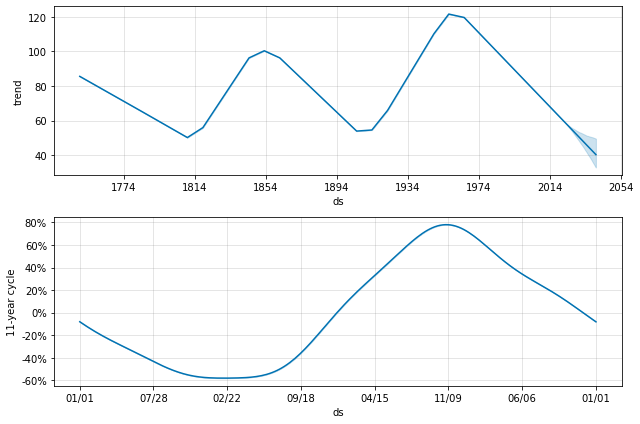

In [49]:
with sup(): model.fit(df)
future = model.make_future_dataframe(periods=240, freq='M')
forecast = model.predict(future)
fig2 = model.plot_components(forecast)
plt.show()

The plot shows just the trend and the 11-year cycle, exactly what we expected. The trend has a sawtooth shape; in fact, scientists have named that trough around 1814 the Dalton Minimum, named after the English meteorologist John Dalton. The peak during the 1950s is called the Modern Maximum. But it's the 11-year cycle that we're interested in here. 

The x-axis can be a bit confusing because it only contains the month and year, but each tick is about 1.5 years later than the previous tick. The whole cycle is indeed 11 years. We can see that the low point is a bit flatter than the high point and has about 60% fewer sunspots than the average. The high point sees about 80% more sunspots than average. 

To see all of the seasonalities that your model currently has, as well as the parameters controlling that seasonality, simply call the seasonalities attribute of the model:

In [50]:
model.seasonalities

OrderedDict([('11-year cycle',
              {'period': 4017.75,
               'fourier_order': 5,
               'prior_scale': 10.0,
               'mode': 'multiplicative',
               'condition_name': None})])

This outputs a dictionary where the keys are the names of the seasonalities and the values are the parameters. In this example, where we only have one seasonality, this is the output dictionary.

<font color='green'> When specifying a period for your seasonality, it is always specified in days. So, a 10-year seasonality will have a period of 10 (years) x 365.25 (days per year) = 3652.5 days. An hourly seasonality would be 1 (day) / 24 (hours per day) = 0.04167 days.
    
<font color='green'> Be careful not to confuse the period of seasonality with the period used in `make_future_dataframe`. The period in seasonality is always specified in days, while the period in `make_future_dataframe` is specified by the `freq` argument.

Adding a seasonality to Prophet that doesn't actually exist in the data can cause Prophet to be very slow to fit, as it struggles to find a pattern where none exists and can actually harm your forecast as Prophet will eventually fit the non-existent seasonality to noise. However, other seasonalities you may find yourself frequently adding may be an hourly seasonality, if your data is measured per minute, as follows:

```python
model.add_seasonality(name='hourly',
                      # an hour is 0.04167 days 
                      period=1 / 24, 
                      # experiment with this value 
                      fourier_order=5)
```

A seasonality for the quarterly business cycle would be created in the following manner:

```python
model.add_seasonality(name='quarterly',
                      # a quarter is 91.3125 days 
                      period=365.25 / 4 
                      # experiment with this value 
                      fourier_order=5)
```

## Adding conditional seasonalities

Suppose you work for a utility company in a college town and are tasked with forecasting the electricity usage for the coming year. The electricity usage is going to depend upon the population of the town to some extent, and as a college town, there are thousands of students who are only temporary residents! How do you set up Prophet to handle this scenario?

Conditional seasonalities exist for this purpose. Conditional seasonalities are those that are in effect for only a portion of the dates in the training and future DataFrames. A conditional seasonality must have a cycle that is shorter than the period in which it is active. So, for example, it wouldn't make sense to have a yearly seasonality that is active for just a few months.

Forecasting electricity usage in the college town would require you to set up either daily or weekly seasonalities—and possibly even both, depending upon the usage patterns, one daily/weekly seasonality for the summer months when students have returned to their hometowns, and another daily/weekly seasonality for the rest of the year. Ideally, the conditional seasonality would have at least two full cycles each time it is active.

To learn how to build a conditional seasonality, we will go back to *the hourly Divvy data* that we explored previously. Based on the weekly seasonality we observed in that example, we know ridership is significantly lower on weekends than weekdays, suggesting most riders are commuting to work.

We saw in the daily seasonality plot that ridership has usage peaks around 8 a.m. and 6 p.m., during the morning and evening rush hours. This may lead you to suspect that the usage throughout the day will follow different patterns on a weekday versus the weekend. That is, maybe those peaks we see at 8 a.m. and 6 p.m. and the midday trough will all disappear on weekends, with activity levels more even throughout the day. To test this hypothesis, let's build a forecast model using different daily seasonalities for weekends than for weekdays. 

The basic procedure for adding this conditional seasonality is to add new Boolean columns to your training DataFrame (and later, matching columns in the future DataFrame) indicating whether that row is a weekend or weekday. Then, disable the default weekly seasonality and add two new weekly seasonalities that specify those new Boolean columns as conditions. Let's see how to do this. 

In [51]:
df = pd.read_csv('data/divvy_hourly.csv')
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y']

Now, this is where we identify the condition for our seasonality. Let's create a function that outputs True if the given date is on a weekend and `False` otherwise. Then, we'll use pandas' `apply` method to create a new column for weekends and use the tilde (`~`) operator to take the inverse results for another new column for weekdays. Finally, let's output the first few rows of our DataFrame at this point just so that we can see what we've got:

In [52]:
def is_weekend(ds):
    date = pd.to_datetime(ds)
    return (date.dayofweek == 5 or date.dayofweek == 6)

df['weekend'] = df['ds'].apply(is_weekend)
df['weekday'] = ~df['ds'].apply(is_weekend)

df.head()

,ds,y,weekend,weekday
0,2014-01-01 01:00:00,1,False,True
1,2014-01-01 02:00:00,9,False,True
2,2014-01-01 03:00:00,4,False,True
3,2014-01-01 04:00:00,1,False,True
4,2014-01-01 07:00:00,2,False,True


January 1, 2014 was a Wednesday, so that output matches what we would expect. Next, we need to instantiate our model. Using what we learned earlier in this chapter, we set the seasonality mode to `multiplicative`, as this Divvy data represents count values. We will also set the Fourier order of both yearly and weekly seasonalities to `6`; my testing showed that to be a good value on this dataset. Finally, because we are adding conditional daily seasonalities, we will disable the default daily seasonality:

In [53]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=6,
                weekly_seasonality=6,
                daily_seasonality=False)

To create conditional seasonalities, we use the same add_seasonality method that we learned about while modeling the sunspot cycle, but in this case, we will use the optional `condition_name` argument to specify that the new seasonality is conditional.

The `condition_name` argument must be passed the name of a column in the training DataFrame consisting of Boolean values identifying which rows to apply the seasonality to—our `weekend` and `weekday` columns. Just as we did in the sunspots example, we also need to name the seasonality and identify both the period and Fourier order:

In [54]:
model.add_seasonality(name='daily_weekend',
                      period=1,
                      fourier_order=3,
                      condition_name='weekend')
model.add_seasonality(name='daily_weekday',
                      period=1,
                      fourier_order=3,
                      condition_name='weekday');

That's it for setting up the model! We will next fit the model on our training data and create the `future` DataFrame just as before, being careful to set the frequency to hourly now that we are using hourly data. The last step in setting up conditional seasonalities is to identify where in the future DataFrame the condition will apply.

We already created the `is_weekend` function and applied it to our training DataFrame, `df`. We simply need to repeat that procedure on the `future` DataFrame before calling predict to create our forecast:

In [55]:
with sup(): model.fit(df)
future = model.make_future_dataframe(periods=365 * 24, freq='h')
future['weekend'] = future['ds'].apply(is_weekend)
future['weekday'] = ~future['ds'].apply(is_weekend)

We named our two conditional seasonalities 'daily_weekend' and 'daily_ weekday', so let's import the plot_seasonality function, which we discovered in the previous chapter, and plot these two seasonalities:

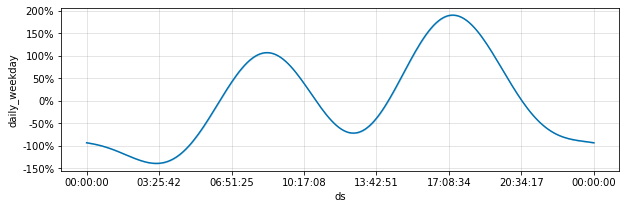

In [56]:
forecast = model.predict(future)
from fbprophet.plot import plot_seasonality
fig3 = plot_seasonality(model, 'daily_weekday', figsize=(10, 3))
plt.show()

On weekdays, the trend appears much the same as we saw when we used the default daily seasonality—a peak around 8 a.m., another peak around 6 p.m., and a small hump just after midnight. Our hypothesis was that weekends would see a much different pattern though. . Let's look at the plot to see:

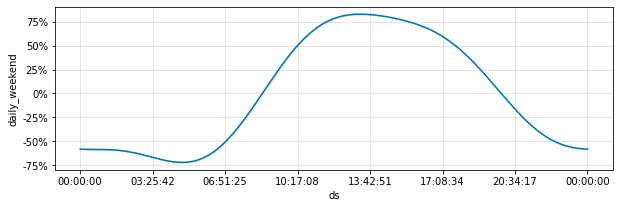

In [57]:
fig4 = plot_seasonality(model, 'daily_weekend', figsize=(10, 3))
plt.show()

And indeed, we do see a difference! As your intuition might have suggested, on the weekends Divvy riders tend to get a later start than on weekdays, with a gradual increase in ridership up until noon and then a gradual decrease all the way to midnight. There is no midday slump as we saw on working days.

## Regularizing seasonality

Regularization is a technique for controlling overfitting by forcing a model to be less flexible. 

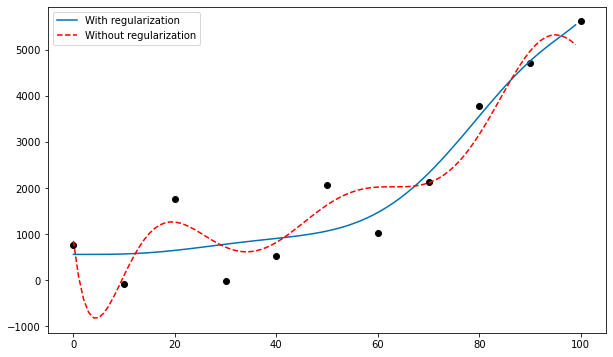

In [58]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

np.random.seed(5)

x_pure = np.arange(0, 100, 1)
y_pure = (x_pure - 20) ** 2 + 50

num_points = 12
x0 = np.arange(0, num_points * 10, 10)
y0 = ((x0 - 20) ** 2 + 50) + np.random.normal(0, 700, num_points)

polynomial_features= PolynomialFeatures(degree=8)
x_poly = polynomial_features.fit_transform(x_pure.reshape(-1, 1))
x0_poly = polynomial_features.fit_transform(x0.reshape(-1, 1))

y1 = Ridge(alpha=0).fit(x0_poly, y0).predict(x_poly)
y2 = Ridge(alpha=1000).fit(x0_poly, y0).predict(x_poly)
y3 = Ridge(alpha=1000000000).fit(x0_poly, y0).predict(x_poly)

plt.figure(figsize=(10, 6))
plt.scatter(x0[:-1], y0[:-1], c='k')
plt.plot(x_pure, y3, label='With regularization', ls='-', c='#0072B2')
plt.plot(x_pure, y1, label='Without regularization', ls='--', c='r')
plt.legend()
plt.show()

The full Prophet package has several adjustable parameters for regularization. For seasonality, that parameter is called the prior scale.

In statistics, you may have an uncertain quantity that you intend to find the value of. The **prior probability distribution**, often just called a prior, of that quantity is the probability distribution of values you would expect **prior** to learning some bit of additional information. 

For example, let's say I ask you to guess the height of a specific human male. In your mind, you imagine all the likely heights of males. That range of heights is the prior probability distribution. Next, I tell you that the male is an NBA basketball player. You know basketball players are typically much taller than the average male, so you update that distribution to skew more toward tall heights because the additional information I provided you with better informs your guess. 

The *prior* is your starting point, what you believe to be true before receiving additional information. Let's see how to apply this idea to seasonality in Prophet.

### Global Seasonality Regularization

The first way to apply seasonality regularization is globally, affecting all seasonalities in your model equally. seasonality_prior_scale is an attribute of your Prophet model instance and is set when you instantiate your model. If you do not set it, the default will be 10. Reducing this number will apply more regularization, which will rein in your model's seasonalities. Let's see this in action. 

We'll use the *Divvy daily* data in this example, so we need to begin by loading it into our Prophet DataFrame, as the necessary libraries should already be loaded from previous examples:

In [59]:
df = pd.read_csv('data/divvy_daily.csv')
df = df[['date', 'rides']]
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y']

Now, we need to instantiate our model, setting the seasonality mode to multiplicative. While learning about Fourier order, you went through a forecast with this dataset using the default seasonality_prior_scale value of 10. So, let's use a prior scale this time around of 0.01. We also found the yearly seasonality to be better modeled with a Fourier order of 4, so we'll set that as well.

In [60]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4,
                seasonality_prior_scale=.01 #control the sesonality regularization
               )

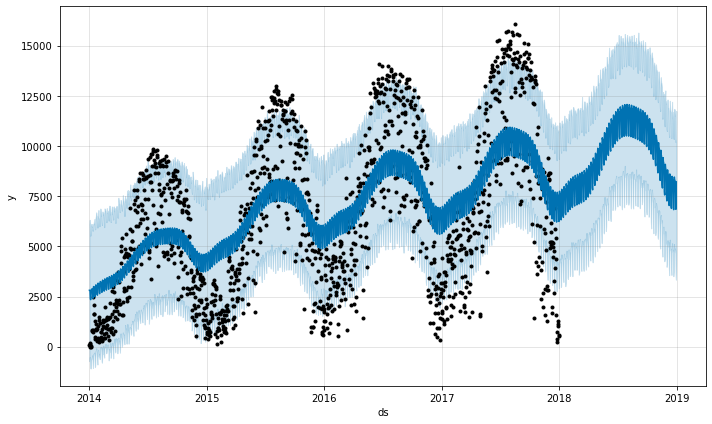

In [61]:
with sup(): model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

Comparing the above Figure with the Figure in cell [39] shows that the seasonal swings in our forecast have indeed been dampened. Both the annual seasonality and the weekly seasonality show less variation. The uncertainty intervals between the two models are roughly the same though, because the variance in the data is now handled in the Prophet model's noise term instead of the seasonality term.

Now, let's look at the components plot:

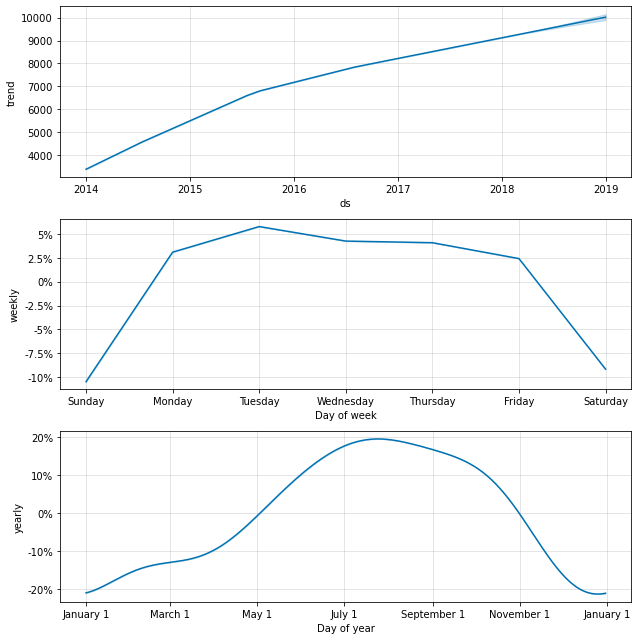

In [62]:
fig2 = model.plot_components(forecast)
plt.show()

Comparing this figure with the figure in cell [40], we see that the trend is very similar. We only constrained the seasonality, not the trend at all. The trend did change a bit (the peak value is a bit higher) because Prophet is attempting to capture some of the seasonal variations with the trend, but the shape is nearly identical. The weekly and yearly seasonalities appear the same, but their y-axes show the magnitudes have been reduced in the range of one third to one quarter of their regularized levels. *This is the effect of seasonality regularization: it reduces the magnitude of the curve's values.*

To illustrate the effect of different seasonality prior scales, let's compare the yearly and weekly seasonality curves of this dataset when modeled with different prior scales. First, here is the yearly seasonality plot:

![](images/4_21.png)

And here is the weekly seasonality plot:
![](images/4_22.png)

The solid line in both plots is the default scale of 10; the dashed line and dashed-dotted line show increasing regularization amounts. Whereas modifying the Fourier order helped control the seasonality curve by reducing the number of bends it was allowed to take, modifying the seasonality prior scale helps control seasonality by reducing the amount of variation it is able to achieve.

### Local seasonality regularization

Let's say that you are happy with the yearly seasonality curve with the default regularization setting, but your weekly curve is too extreme and overfitting. In that case, you can use the add_seasonality method to create a new weekly seasonality with a custom prior scale. 

Let's continue on and instantiate a new model, again with multiplicative seasonality and a Fourier order of 4 applied to the yearly seasonality. This time though, we will be adding a new weekly seasonality, so let's remove the default by setting it to False while instantiating:

In [63]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4,
                weekly_seasonality=False)

As you learned in the section on custom seasonalities, we will now add a seasonality with a period of 7 days and name it 'weekly'. We are happy with the default weekly Fourier order of 4, so we'll use that again here, but we want more regularization than is the default, so we use the prior_scale argument to set it to 0.01:

In [65]:
model.add_seasonality(name='weekly',
                      period=7,
                      fourier_order=4,
                      prior_scale=0.01);

Now, as I hope is becoming second nature to you, we will fit the model and predict on the future DataFrame. Let's just plot the components this time:

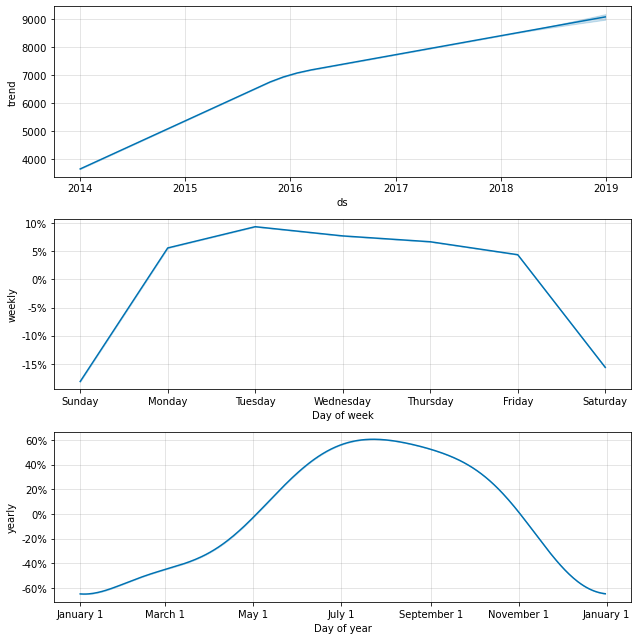

In [66]:
with sup(): model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig2 = model.plot_components(forecast)
plt.show()

You'll now see that the magnitude of the unregularized yearly seasonality matches that of the figure in cell [40], but the regularized weekly seasonality is reduced by about half, as expected. All of your seasonalities can have different regularization strengths applied, simply with repeated add_seasonality calls. Reasonable values for these prior scales range from about 10 down to around 0.01.

# Growth Models

Until now, every forecast we've built followed only one growth mode: linear. The trend sometimes had some small bends where the slope either increased or decreased, but fundamentally the trend consisted of linear segments. However, Prophet features two additional growth modes: **logistic** and **flat**.

Modeling your time series with a growth mode that is not optimal can often fit the actual data very well. But, as you'll see in this chapter, even if the fit is realistic, the future forecast can become wildly unrealistic. Sometimes the shape of the data will inform which growth mode to choose and sometimes you'll need domain knowledge and a bit of common sense. This chapter will help guide you to an appropriate selection. Furthermore, you will learn when and how to apply these different growth modes. Specifically, this section will cover the following:
- Applying linear growth 
- Understanding the logistic function 
- Saturating forecasts 
- Applying flat growth

## Applying linear growth

All the models we built previously had the default growth mode, linear. This means that the trend consists of a straight, sloped line, or potentially a few straight, sloped lines connected at changepoints, *Trend Changepoints*. For now, though, let's load up our Divvy data again and focus on the growth.

In [68]:
from fbprophet.plot import add_changepoints_to_plot

This new function will allow us to easily plot our trend line directly on our forecast plot.

As we've done previously, let's open the Divvy data and load it into our training DataFrame:

In [70]:
df = pd.read_csv('data/divvy_daily.csv')
df = df[['date', 'rides']]
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y']

We learned already, that this dataset should be modeled with multiplicative seasonality and that the yearly seasonality should be constrained a bit by setting the Fourier order to 4. We'll set these values when instantiating our model. We'll also explicitly set `growth='linear'`. This is the default, and previously we just implicitly accepted it, but for clarity's sake we'll include it here:

In [77]:
model = Prophet(growth='linear', seasonality_mode='multiplicative',
                yearly_seasonality=4)

Just as we did when we modeled the daily Divvy data in the seasonality section, we will next fit the model, build a future DataFrame with one year to forecast, predict future values, and plot the forecast. This time, however, we will use the `add_changepoints_` to_plot function.

The function requires that we specify which plot axes to use, identify the model we created, and identify the forecast DataFrame output from the `predict` method. For the axes, we use the Matplotlib `gca` method, for get *current axes*, and call it on the figure created when plotting the forecast. You can see the syntax in the following code. We are only using the plot changepoints function here to plot the trend so we will remove the changepoint markers for now using `cp_linestyle=''`:

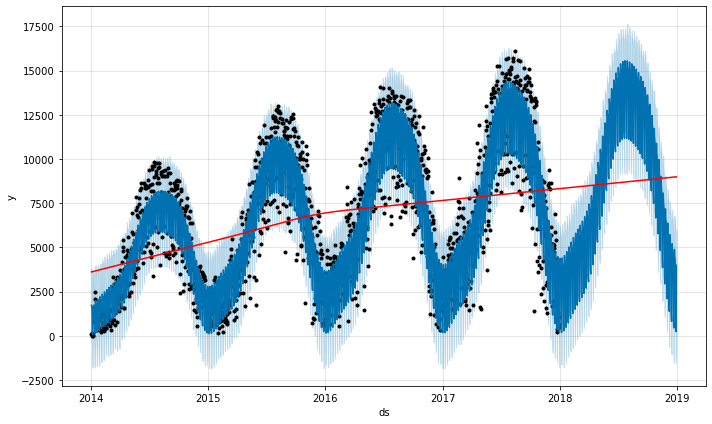

In [78]:
with sup(): model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast, cp_linestyle='')
plt.show()

Remember, Prophet is an additive regression model. So, the trend is the most fundamental building block of our forecast. We add detail and variation to it by adding seasonalities, holidays, and additional regressors. The trend you see in the preceding figure (the solid line cutting through the midpoints of each sine period) is the Divvy plot with seasonality removed (we never added holidays in this example).

As you can see, the trend is a straight segment from 2014 until late 2016, then a slight bend and another straight segment, with a shallower slope, from 2016 onward. Despite that bend, it is fundamentally linear. 

Let's now look at the next growth mode, logistic. To understand this growth mode, you first need to understand the logistic function.

## Understanding the logistic function

The logistic function generates an S-shaped curve; the equation takes the following form:

$$
y=\frac{L}{1+e^{-k\left(x-x_{0}\right)}}
$$

Here, $L$ is the maximum value of the curve, $k$ is the logistic growth rate, or steepness, of the curve, and $x_0$ is the $\mathrm{x}$-value of the curve's midpoint.

Taking $L=1, k=1$, and $x_{0}=0$, the logistic function produces the **standard logistic function**, seen in the following plot:

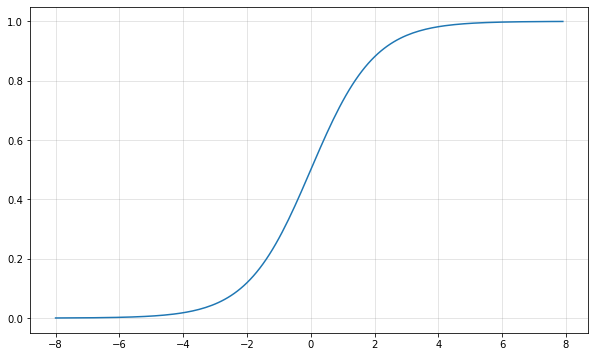

In [80]:
x = np.arange(-8, 8, .1)
y = [1 / (1 + np.e**(-val)) for val in x]

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
plt.show()

If you have studied logistic regression or neural networks, you may recognize this as the sigmoid function. Any input value for x, from -∞ to ∞, will be squished into an output value, y, between 0 and 1. This equation is what allows a logistic regression model to accept any input value and output a probability between 0 and 1. 

The equation was developed by Pierre François Verhulst, a Belgian mathematician, in a series of three papers published between 1838 and 1847. Verhulst was working to model the population growth of Belgium.

Population growth approximately follows an initial exponential growth rate, then a linear, also known as arithmetic, growth rate, until the population hits a saturation point, where growth slows to zero. This is the shape you see in the preceding plot, starting at the curve's midpoint and moving right. Verhulst invented the term logistic to be analogous to arithmetic and geometric but derived from logarithmic. Don't get the word confused with logistics, as referring to the handling of details. They have completely different origins.

Prophet's logistic growth mode follows this general curve. The curve's saturation levels are the upper and lower bounds, which the curve asymptotically approaches. 

Besides applications in statistics and machine learning, where the logistic curve is used in logistic regression and neural networks, the logistic function is also often used to model population growth, either of humans as in Verhulst's Belgium or of animals as we will do in this section. It is used often in medicine to model the growth of tumors, bacterial or viral loads in an infected person, or infection rates of people during a pandemic. 

In economics and sociology, the curve is used to describe the adoption rate of new innovations. Linguists use it to model language changes. It can even be used to model the spread of a rumor or new idea throughout a population.

## Saturating forecasts

In the early 1800s, westward expansion in the United States brought many settlers and their livestock into contact with the native wolf population. These wolves began to prey o the domestic stock, which resulted in the settlers hunting and killing the wolves in order to protect their own animals. The gray wolf was still present on the land which became Yellowstone National Park when it was established in 1872, but over the next few decades they were hunted nearly to extinction in the region and throughout the lower 48 states.

In the 1960s, the public began to understand the idea of ecosystems and the interconnectedness of species, and in 1975, the decision to restore wolf populations to Yellowstone was taken, with 31 gray wolves finally being relocated to the park from Canada in 1995. This provided an almost perfect experiment of natural population growth inside the park. 

We'll look at this population in the next few examples. However, we'll be using simulated data because the true data is spotty throughout the historical record. As the wolves tend to avoid human contact, counting their number can never be exact and so accurate data is lacking. Furthermore, there are numerous compounding factors that we will not model (and are generally unpredictable, as well).

To understand these compounding factors, consider the example of Isle Royale, an island on Michigan's Lake Superior that has had a moose and wolf population under continuous study since 1959. This is, in fact, the longest continuous study of any predator-prey population system in the world. As can be seen in the following plot, it has not been a predictable system, to say the least:

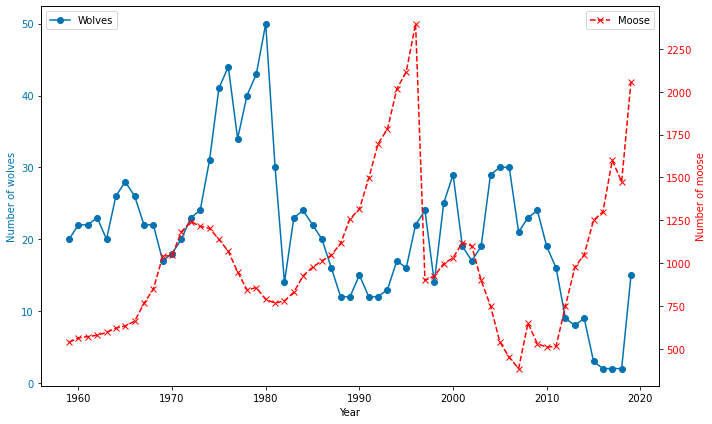

In [82]:
# First install openpyxl using conda or pip
ir = pd.read_excel('data/Data_wolves_moose_Isle_Royale_June2019.xlsx',
                     sheet_name='1. population level data',
                     header=1)

fig, ax1 = plt.subplots(figsize=(10, 6))
color = '#0072B2'
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of wolves', color=color)
ax1.plot(ir['year'], ir['wolves'], color=color, ls='-', marker='o', label='Wolves')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'r'
ax2.set_ylabel('Number of moose', color=color)  # we already handled the x-label with ax1
ax2.plot(ir['year'], ir['moose'], color=color, ls='--', marker='x', label='Moose')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In the 1960s and 1970s, rising moose populations provided food, which allowed wolf populations to double. But in 1980, humans inadvertently introduced canine-parvovirus, a disease that caused the wolf population to collapse. The moose population in turn rose again with the decline of its only predator, only to collapse itself in 1996 with the double stresses of the most severe winter on record and an unpredictable outbreak of moose ticks.

Throughout the 1990s, the wolf population was too low for healthy breeding, leading to intense levels of inbreeding, which held their population down, only rebounding when a single wolf reached the island by crossing winter ice from Canada in the late 1990s. Following this, the wolf population increased throughout the early twenty-first century, despite declining moose numbers. All this is to say that small, isolated populations represent a very dynamic system that cannot be accurately predicted when not in isolation from natural external events.


### Increasing logistic growth

To synthesize a somewhat realistic population of wolves in Yellowstone, let's suppose that 100 wolves were introduced in 1995. Park ecologists surveyed the area and determined that the land could support a total population of 500 wolves.

In the linear growth example, we imported *pandas*, *matplotlib*, *Prophet*, and the `add_changepoints_to_plot` function, so to continue we only need to import the numpy and random libraries in order to create our dataset. Be sure to set the random seed so that every time we run the code we get the same pseudo-random results.

We will simulate the wolf population by first creating a series of monthly dates, from 1995 until 2004. At every date, we'll calculate the output from our logistic equation. Then, we'll add some sinusoidal variation to account for yearly seasonality, and finally some random noise. Then, we just need to scale our curve up:

In [83]:
x = pd.to_datetime(pd.date_range('1995-01', '2004-02', freq='M').strftime("%Y-%b").tolist())
y = [1 / (1 + np.e ** (-.03 * (val - 50))) for val in range(len(x))]  # create logistic curve
y = [y[idx] + y[idx] * .01 * np.sin((idx - 2) * (360 / 12) * (np.pi / 180)) for idx in range(len(y))]  # add sinusoidal variation
y = [val + random.uniform(-.01, .01) for val in y]  # add noise
y = [int(500 * val) for val in y]  # scale up

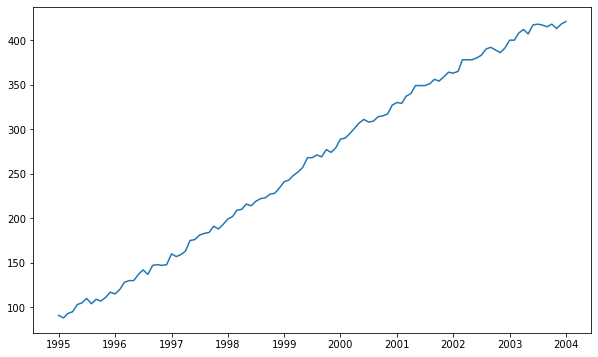

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.show()

Let's begin our analysis of this data by fitting a Prophet model with linear growth. This example will demonstrate what can go wrong when choosing an inappropriate growth mode.

#### Modeling with linear growth

As we did earlier, we start by organizing our data into a DataFrame for Prophet:

In [85]:
df = pd.DataFrame({'ds': pd.to_datetime(x), 'y': y})

In addition to linear growth, let's set the Fourier order of the yearly seasonality to 3 and the seasonality mode to `multiplicative`. Then, we fit our DataFrame and create the `future` DataFrame. We simulated this data at a monthly frequency, so we'll forecast out `10` years and set `freq='M'`. After predicting on the future, we'll plot the forecast and use the `add_changepoints_to_plot` function to overlay the trend:

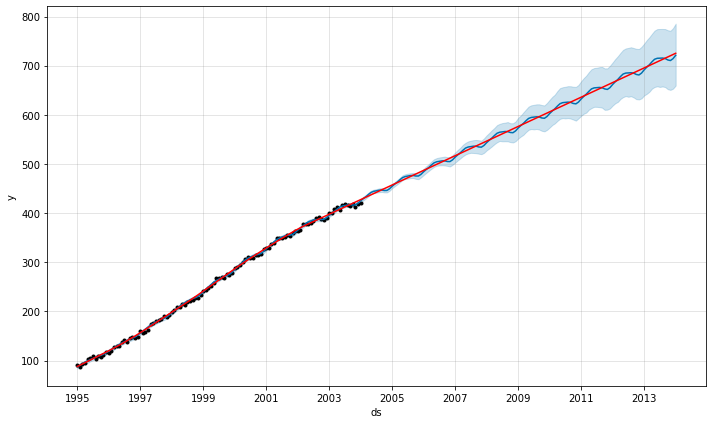

In [86]:
model = Prophet(growth='linear',
                yearly_seasonality=3,
                seasonality_mode='multiplicative')
with sup(): model.fit(df)
future = model.make_future_dataframe(periods=12 * 10, freq='M')
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast, cp_linestyle='')
plt.show()

Immediately, you should see what will go wrong with using a linear trend in a situation where the forecast will naturally saturate at some level. The predicted values will keep rising toward infinity with longer and longer forecast time periods.

Obviously, this cannot be realistic. There is only so much food for the wolves to eat; at a certain point, there won't be enough food and the wolves will begin starving. Let's now model this with logistic growth and see what happens.

#### Modeling with logistic growth

With **logistic** growth, Prophet always requires that a **ceiling** be stated—a value that your forecast will not ever surpass. In cases where growth is declining, a floor must be stated as well. In this example, though, we have increasing growth, so we'll only set the ceiling. Prophet refers to it as a **cap**. To add this to Prophet, we need to create a new column in our training DataFrame called `cap` and also mimic it in our `future` DataFrame. 

In general, determining a cap may pose some difficulties. If your curve is near the saturation level already, you can see better what value it is approaching and choose it. If not, however, then a little domain knowledge will really be your best solution. Before you can model logistic growth rates, you must have some idea of where the saturation level will eventually be. Usually, this cap is set using data or with special expertise about market size. For our example, we'll set the cap to `500`, as that was the value estimated by the ecologists:

In [87]:
df['cap'] = 500

Next, we continue just as we did in the previous example, but this time let's set the growth mode to logistic, before fitting and creating the `future` DataFrame:

In [88]:
model = Prophet(growth='logistic',
                yearly_seasonality=3,
                seasonality_mode='multiplicative')
with sup(): model.fit(df)
future = model.make_future_dataframe(periods=12 * 10, freq='M')

We need to add the cap to our future DataFrame as well:

In [89]:
future['cap'] = 500

Now when we predict and plot the forecast, you'll see quite a differently shaped curve:

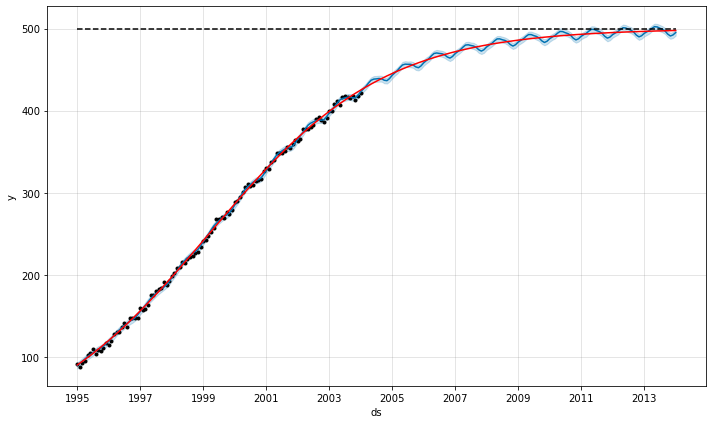

In [90]:
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast, cp_linestyle='')
plt.show()

By default, Prophet displays the cap, and floor if present, as horizontal dashed lines in your plot.

With logistic growth, the wolf population is allowed to grow at roughly the same rate for several years. The growth rate slows as it approaches its saturation point, the greatest population that the natural resources available can support. After this point, the growth rate stays flat with just a bit of seasonal variation as old wolves die in the winter and spring pups arrive.


### Non-constant cap

It is important to note that the cap does not necessarily need to be constant. If you are forecasting sales, for example, your saturation limit will be the market size. But this market size may be growing as various factors cause more consumers to consider purchasing your product. Let's look at a quick example of how to model this. We assumed that the wolf population in Yellowstone was constrained by the size of the park. 

Let's now create a hypothetical situation where the park size is gradually increased starting in 2007, creating conditions that allow for two additional wolves per month. Let's create a function to set the cap. For dates prior to 2007, we will keep the park's saturation limit of `500`. For all dates starting in `2007`, though, we will increase the cap by two per month:

In [91]:
def set_cap(row, df):
    if row.year < 2007:
        return 500
    else:
        pop_2007 = 500
        idx_2007 = df[df['ds'].dt.year == 2007].index[0]
        idx_date = df[df['ds'] == row].index[0]
        return pop_2007 + 2 * (idx_date - idx_2007)

Now, let's set the cap for our training DataFrame, `df`:

In [92]:
df['cap'] = df['ds'].apply(set_cap, args=(df,))

The cap should remain `500` throughout, as our training data ends in 2004. Now, let's create our model the same as before, but set our `future` DataFrame using the `set_cap` function:

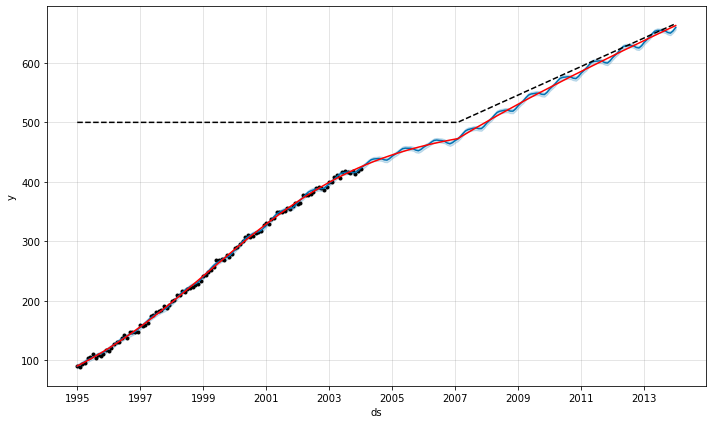

In [93]:
model = Prophet(growth='logistic',
                yearly_seasonality=3,
                seasonality_mode='multiplicative')
with sup(): model.fit(df)
future = model.make_future_dataframe(periods=12 * 10, freq='M')
future['cap'] = future['ds'].apply(set_cap, args=(future,))
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast, cp_linestyle='')
plt.show()

Now, you can see that the wolf population is asymptotically approaching our increasing cap.

The cap is simply a value set for each row in the DataFrame; for every date, you can set whichever value makes sense. The cap may be constant as in our first example, or it may vary linearly, as we have just done here, or it may follow any arbitrary curve of your choosing. Now let's look at the reverse situation, a hypothetical situation where the wolf population is sadly declining and approaching extinction.

### Decreasing logistic growth

The only difference in this example is that we must also state a floor value in addition to a `cap` value. Let's build another psuedo-random dataset but with negative growth:

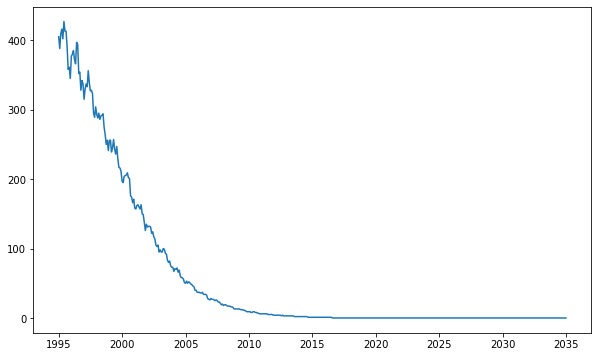

In [94]:
x = pd.to_datetime(pd.date_range('1995-01','2035-02', freq='M').strftime("%Y-%b").tolist())
y = [1 - 1 / (1 + np.e ** (-.03 * (val - 50))) for val in range(len(x))]  # create logistic curve
y = [y[idx] + y[idx] * .05 * np.sin((idx - 2) * (360 / 12) * (np.pi / 180)) for idx in range(len(y))]  # add sinusoidal variation
y = [val + 5 * val * random.uniform(-.01, .01) for val in y]  # add noise
y = [int(500 * val) for val in y]  # scale up
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.show()

For our forecast in this case, we'll cut off the data at 2006 and attempt to predict when there will be no more wolves in the population. When creating our DataFrame, we specify both a cap value, as we did previously, and a `floor` value:

In [95]:
df2 = pd.DataFrame({'ds': pd.to_datetime(x), 'y': y})
df2 = df2[df2['ds'].dt.year < 2006]
df2['cap'] = 500
df2['floor'] = 0

We'll complete the model all in one step. Everything is the same as before, except this time we also set `floor` in the `future` DataFrame:

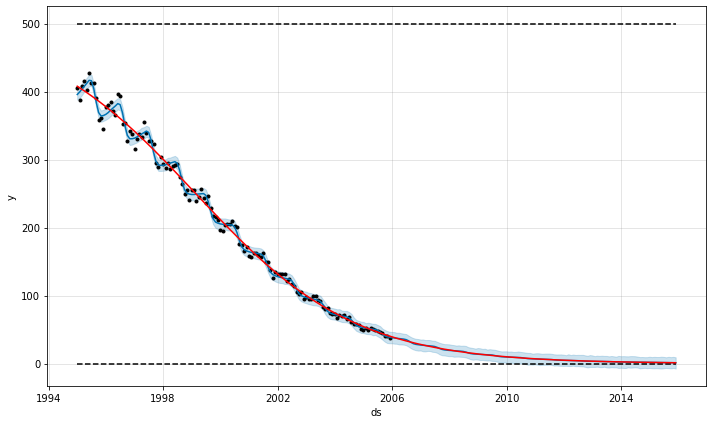

In [96]:
model = Prophet(growth='logistic',
                yearly_seasonality=3,
                seasonality_mode='multiplicative')
with sup(): model.fit(df2)
future = model.make_future_dataframe(periods=12 * 10, freq='M')
future['cap'] = 500
future['floor'] = 0
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast, cp_linestyle='')
plt.show()

Prophet will predict precise decimal values and of course wolves exist in integer values, but this plot shows that somewhere between 2010 and 2014, the wolf population will die off. In a real scenario, it also matters greatly whether the last few remaining wolves are part of a breeding pair, and we have ignored that factor here.

Notice that because we have specified both a cap and a floor, Prophet has plotted both as horizontal dashed lines. When logistic growth is declining, even if there is no relevant cap, as is the case here, one must be included in your model. You may choose one that is arbitrarily high with no effect on your model, although be aware that it will be included in your plot and may make it appear as if Prophet's forecast is very low. 

You can, however, exclude it from your plots by including the `plot_cap` argument as done here: `fig = model.plot(forecast, plot_cap=False)`, which modifies both the cap and the floor. Prophet does not currently support the exclusion of only one of these from your plot. 

Prophet currently supports one more growth mode: no growth. However, the Prophet team is at work on some other modes at the time of writing and those may become available soon, so keep an eye on the documentation. Let's take a look at this final growth mode.

## Applying flat growth

**Flat growth** is when the trend line is perfectly constant throughout the data. The data's values only differ due to seasonality, holidays, extra regressors, or noise. To see how to model flat growth, let's continue on with our wolf population but this time consider far into the future when the population has fully stabilized. Let's begin by creating a new dataset, essentially the same as our logistic growth dataset but with a much longer timeframe:

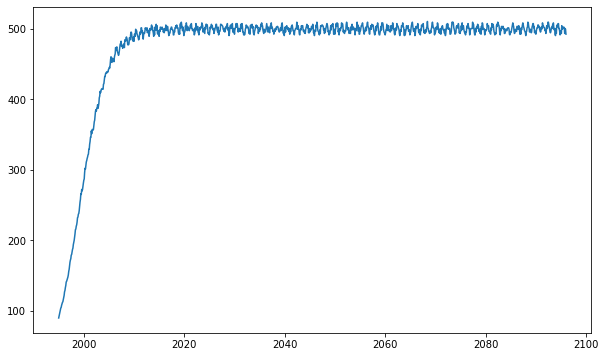

In [97]:
x = pd.to_datetime(pd.date_range('1995-01','2096-02', freq='M').strftime("%Y-%b").tolist())
y = [1 / (1 + np.e ** (-.03 * (val - 50))) for val in range(len(x))]  # create logistic curve
y = [y[idx] + y[idx] * .01 * np.sin((idx - 2) * (360 / 12) * (np.pi / 180)) for idx in range(len(y))]  # add sinusoidal variation
y = [val + 1 * val * random.uniform(-.01, .01) for val in y]  # add noise
y = [int(500 * val) for val in y]  # scale up
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.show()

We are now looking forward a century from when the wolves were re-introduced into the park.

After this length of time, the wolf population has reached the saturation point and is fully stabilized. We will now create our training DataFrame, but then only limit our data to the last decade of the range, where the overall trend is already well saturated:

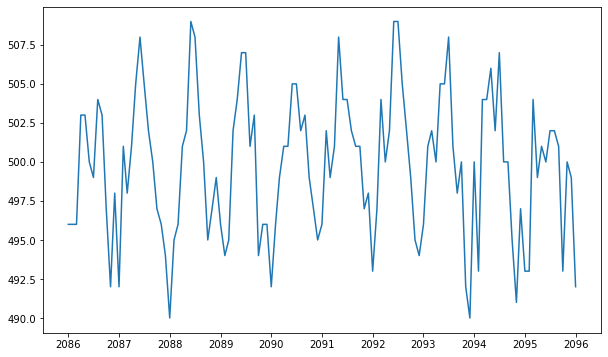

In [98]:
df = pd.DataFrame({'ds': pd.to_datetime(x), 'y': y})
df = df[df['ds'].dt.year > 2085]
plt.figure(figsize=(10, 6))
plt.plot(df['ds'], df['y'])
plt.show()

Let's first use the default linear growth to see what could go wrong:

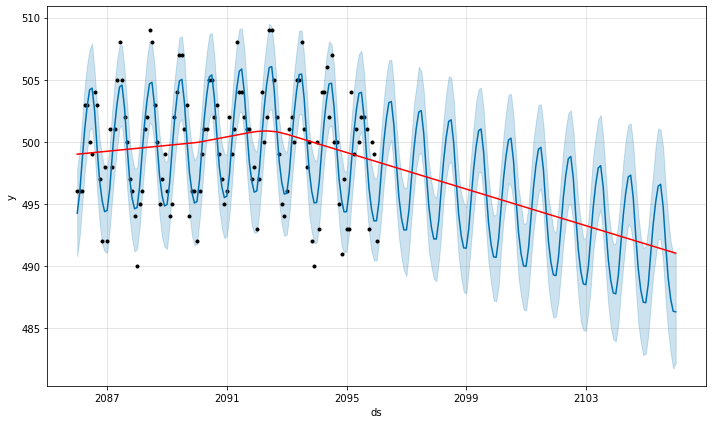

In [99]:
model = Prophet(growth='linear', yearly_seasonality=3,
                seasonality_mode='multiplicative')
with sup(): model.fit(df)
future = model.make_future_dataframe(periods=12 * 10, freq='M')
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast, cp_linestyle='')
plt.show()

Due to random noise in the data, Prophet will find brief areas where there seems to be a trend, either positive or negative. If one of these periods occurs at the end of the training data, then that curve will continue for the entire output of forecasted future data.

As you can see, Prophet predicts that the wolf population is decreasing even though it is quite stable. Furthermore, the uncertainty intervals are growing; Prophet is smart enough to know this isn't quite right. Now let's model this correctly—with flat growth. Because the trend will be constant, setting a seasonality mode is irrelevant. It will still be calculated as either additive or multiplicative, but the end result will be the same in either case. We will ignore it here.

Creating a model with flat growth is as simple as setting `growth='flat'` during model instantiation:


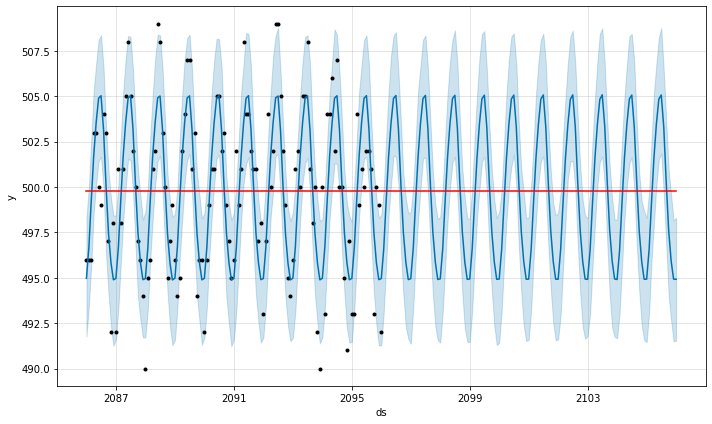

In [100]:
model = Prophet(growth='flat', yearly_seasonality=3)
with sup(): model.fit(df)
future = model.make_future_dataframe(periods=12 * 10, freq='M')
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast, cp_linestyle='')
plt.show()

No matter how far out we forecast, the trend will be stable. The only variation in Prophet's model in this example comes from the yearly seasonality as we added no holidays and neither daily nor weekly seasonalities were included.

# Additional Regressors

In your first model with Facebook Prophet, you forecasted carbon dioxide levels at Mauna Loa, using only the date, but no other information, to predict future values. For example, the way holidays are implemented in Prophet is actually a special case of adding a binary regressor.
In fact, Prophet includes a generalized method for adding any additional regressor, both binary and continuous. 

In this section, you'll enrich your Divvy dataset with weather information by including it as an additional regressor. First, you will add binary weather conditions to describe the presence or absence of sun, clouds, or rain, and then next you will bring in continuous temperature measurements. Using additional regressors can allow you to include more information to inform your models, which leads to greater predictive power. 

In this section, you will learn about the following topics: 
- Adding binary regressors 
- Adding continuous regressors 
- Interpreting the regressor coefficients

## Adding binary regressors

The first thing to consider with **additional regressors**, whether binary or continuous, is that you must have known future values for your entire forecast period. This isn't a problem with holidays because we know exactly when each future holiday will occur. All future values must either be known, as with holidays, or must have been forecast themselves separately. You must be careful though when building a forecast using data that itself has been forecast: the error in the first forecast will compound the error in the second forecast, and the errors will continuously pile up. 

If one variable is much easier to forecast than another, however, then this may be a case where these stacked forecasts do make sense. A **hierarchical time series** is an example case where this may be useful: you may find good results by forecasting the more reliable daily values of one time series, for instance, and using those values to forecast hourly values of another time series that is more difficult to predict.

In the examples in this section, we are going to use a weather forecast to enrich our Divvy forecast. This additional regressor is possible because we generally do have decent weather forecasts available looking ahead a week or so. In other examples, in which we have used Divvy data, we often forecasted out a full year. In this section though, we will only forecast out 2 weeks. Let's be generous to Chicago's weather forecasters and assume that they'll provide accurate forecasts in this time frame.

To begin, let's import our necessary packages and load the data:

In [101]:
df = pd.read_csv('data/divvy_daily.csv')

Previously, we always excluded the two columns for weather and temperature in this dataset, but we'll use them this time around. For our first example, let's consider the weather conditions. By counting the number of times each condition occurred in the dataset, we can see their frequencies:

In [102]:
print(df.groupby('weather')['weather'].count())

weather
clear             41
cloudy          1346
not clear          2
rain or snow      69
Name: weather, dtype: int64


By grouping the data by weather and aggregating by count, we can see the number of days each condition was reported. `clear` weather occurred on 41 days, and `cloudy` weather was by far the most common, with 1346 occurrences. `not clear` was only reported twice, and `rain` or `snow` 69 times.

Now that we understand what data we're working with, let's load it into our DataFrame. We'll also load the temperature column even though we won't use it until the next example when we look at **continuous** columns, those in which the value may exist along a continuum.

To load the weather column, we will use pandas' get_dummies method to convert it into four **binary** columns for each unique weather condition, meaning that each column will be a 1 or a 0, essentially a flag indicating whether the condition is present:

In [103]:
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y', 'temp', 'weather']
df = pd.get_dummies(df, columns=['weather'], prefix='', prefix_sep='')

In [104]:
df.head()

,ds,y,temp,clear,cloudy,not clear,rain or snow
0,2014-01-01,95,19.483158,0,0,0,1
1,2014-01-02,111,16.833333,0,0,0,1
2,2014-01-03,6,-5.633333,1,0,0,0
3,2014-01-04,181,30.007735,0,0,0,1
4,2014-01-05,32,16.756250,0,0,0,1


You can now see that each unique value in the `weather` column has been converted to a new column. Let's instantiate our model now, setting the seasonality mode to multiplicative and the yearly seasonality to have a Fourier order of 4, as we did in previous sections.

We will also add in our additional regressors using the `add_regressor` method. As arguments to this method, you must pass the name of the regressor, which is the name of the corresponding column in your DataFrame. You may also use the `prior_scale` argument to regularize the regressor, similarly as we could work with holidays, seasonalities, and trend changepoints. If no prior scale is specified, then `holidays_prior_scale` will be used, which defaults to 10.

You may also specify whether the regressor should be additive or multiplicative. If nothing is specified, then the regressor adopts that stated in `seasonality_mode`. Lastly, the method has a `standardize` argument, which, by default, takes the string 'auto'. This means that the column will be standardized if not binary. You can instead explicitly set standardization by setting it to either `True` or `False`. In this example, all defaults will work out great. 

To make it clear, I'll explicitly state all arguments in only the first `add_regressor` call and, for the remaining, we will only state the name of the regressor and otherwise accept all default values.

We must make one `add_regressor` call for each additional regressor but note that we are leaving the regressor for `cloudy` out. For Prophet to get accurate forecast results, this isn't strictly necessary. However, because including all four binary columns will introduce **multicollinearity**, this makes interpreting the individual effect of each condition difficult, so we will exclude one of them. However, Prophet is fairly robust to multicollinearity in additional regressors, so it shouldn't affect your final results significantly.

When we called `pd.get_dummies earlier`, we could have specified the `drop_ first=True` argument to exclude one of the conditions, but I decided not to so we could choose for ourselves which column to exclude. The cloudy condition is by far the most frequent, so by excluding it we are essentially stating that `cloudy` is the default weather condition and the other conditions will be stated as deviations from it:

In [106]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4)
model.add_regressor(name='clear',
                    prior_scale=10,
                    standardize='auto',
                    mode='multiplicative')
model.add_regressor('not clear')
model.add_regressor('rain or snow');

Now, remembering that we need future data for our additional regressors and we're only going to forecast out two weeks, we need to artificially reduce our training data by two weeks to simulate having two future weeks of weather data but no ridership data. To do that, we'll need to import `timedelta` from Python's built-in datetime package. 

Using Boolean indexing in pandas, we will create a new DataFrame for training data, called `train`, by selecting all dates that are less than the final date (`df['ds'].max()`) minus two weeks (`timedelta(weeks=2)`):

In [107]:
from datetime import timedelta

# Remove final 2 weeks of training data
train = df[df['ds'] < df['ds'].max() - timedelta(weeks=2)]

At this point, we are essentially saying that our data ends not on December 31, 2017 (as our `df` DataFrame does), but on December 16, 2017, and that we have a weather forecast for those two missing weeks. We now fit our model on this `train` data and create our `future` DataFrame with 14 days. 

At this point, we need to add those additional regressor columns into our future DataFrame. Because we created that `train` DataFrame instead of modifying our original df DataFrame, those future values for the weather are stored in `df` and we can take them to use in our `future` DataFrame. Finally, we will predict on the future.

The forecast plot is going to look similar to our previous Divvy forecasts, so let's just skip it and go straight to the `components` plot:

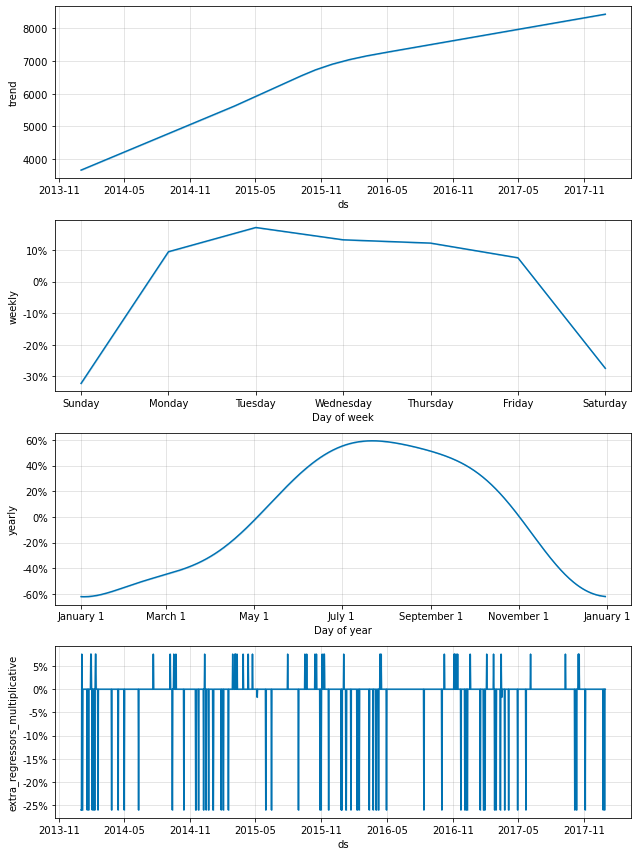

In [108]:
with sup(): model.fit(train)

future = model.make_future_dataframe(periods=14)
future['clear'] = df['clear']
future['not clear'] = df['not clear']
future['rain or snow'] = df['rain or snow']
forecast = model.predict(future)

fig2 = model.plot_components(forecast)
plt.show()

This time, you will see a new subplot included with the other components. The following image is a crop of the full `components` plot and only shows the yearly seasonality and this new component.

The trend, weekly seasonality, and yearly seasonality, which were cropped out, look much the same as we've seen before with this dataset. However, we have a new addition to the components plot, called `extra_regressors_multiplicative`. Had we specified some of those regressors as additive, we would see a second subplot here, called `extra_regressors_additive`.

On dates where the value is at 0%, these are our baseline dates when the weather was cloudy, which we left out of the additional regressors. The other dates are those where the weather deviated from cloudy, which we included. We'll take a more in-depth look at this in a bit. But first, let's bring temperature into our model and add a continuous regressor.

## Adding continuos regressors

In this example, we will take everything from the previous example and simply add in one more regressor for temperature. Let's begin by looking at the temperature data:

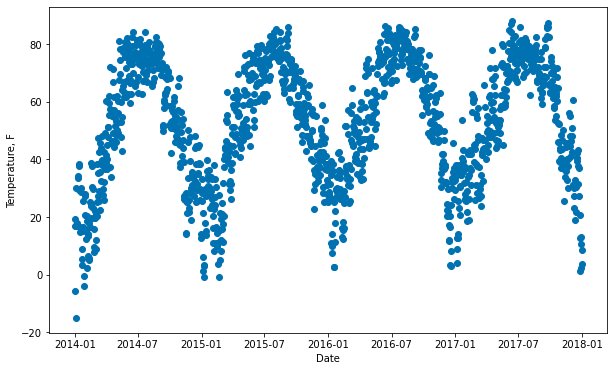

In [109]:
plt.figure(figsize=(10, 6))
plt.scatter(pd.to_datetime(df['ds']), df['temp'], c='#0072B2')
plt.xlabel('Date')
plt.ylabel('Temperature, F')
plt.show()

There's nothing too surprising about the preceding plot; daily temperatures rise in summer and fall in winter. It does look a lot like the number of riders but without that increasing trend. Clearly, Divvy ridership and the temperature rise and fall together.

Adding temperature, a continuous variable, is no different than adding binary variables. We simply add another `add_regressor` call to our Prophet instance, specifying `'temp'` for the name, and also including the temperature forecast in our `future` DataFrame. As we did before, we are fitting our model on the `train` DataFrame we created, which excludes the final 2 weeks' worth of data. Finally, we plot the components to see what we've got:

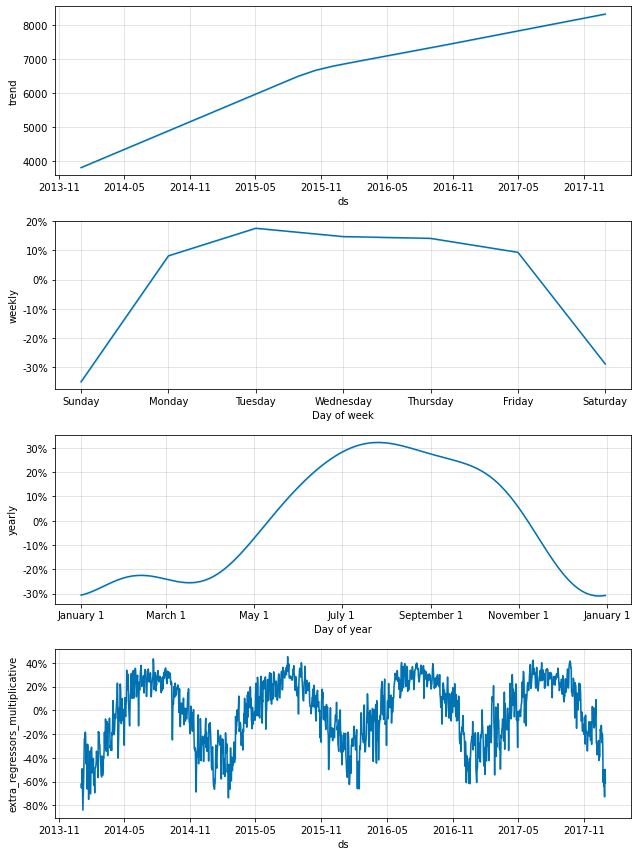

In [110]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=4)
model.add_regressor('temp')
model.add_regressor('clear')
model.add_regressor('not clear')
model.add_regressor('rain or snow')

with sup(): model.fit(train)

future = model.make_future_dataframe(periods=14)
future['temp'] = df['temp']
future['clear'] = df['clear']
future['not clear'] = df['not clear']
future['rain or snow'] = df['rain or snow']
forecast = model.predict(future)

fig2 = model.plot_components(forecast)
plt.show() 

Now, the `extra_regressors_multiplicative` plot shows the same fluctuations that our temperature plot displayed:

Also note that in the previous figure of the components, the yearly plot peaked at 60% effect magnitude. However, now we can see that temperature accounts for some of that effect. The yearly plot in the previous components figure shows a peak 30% effect, while the extra_regressors_multiplicative plot shows a 40% increase on certain summertime dates and a massive 80% decrease in ridership on certain wintertime dates. To break this down further, we now need to discuss how to interpret this data.

# References 

There is a lot of issues that cannot cover here. I would recommend to read the chapters 5,7,9, 10 of [2], but especially the chapters 11 and 12, which shows how to do cross validation and tuning hyperparameters with grid search.

[1] Taylor, S.J. and Letham, B., 2018. Forecasting at scale. The American Statistician, 72(1), pp.37-45.

[2] Gerg Rafferty, Forecasting Time Series Data with Facebook Prophet. Packt, 2021.